# Novel Drug Approvals (2015 - 2024)

> **Goal:** This notebook will look at New Molecular Entities (NMEs) approved by the FDA. <br>
> **Notebook Owner(s):** Time Bioventures <br>
> **Date:** June 2024 <br>

***
## Import Libraries

Import the libraries you will be using throughout the project.

In [30]:
import os
import re
import sys
import time
import tqdm
import string
import datetime
import requests
import textwrap
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import defaultdict
# turn off lxml warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# pubchempy is a Python wrapper for the PubChem PUG REST API
import pubchempy as pcp
# pytrials is a Python wrapper for the ClinicalTrials.gov API
from pytrials.client import ClinicalTrials
# custom functions
from utils.webpage_scraping import test_connection
from utils.text_search import find_drug, find_df_overlap
from utils.pickle_dataframes import pickle_dataframe, unpickle_dataframes, read_excel
# auto reload custom functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
## Scrape NME Tables

Utilize [BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/) to scrape all the NME tables (example: [2024 NMEs](https://www.fda.gov/drugs/novel-drug-approvals-fda/novel-drug-approvals-2024)) row-by-row, making sure you also capture the links for additional drug information.

In [2]:
def initialize_df():
	df = pd.DataFrame({
		"year": [],
		"year_approval_count": [],
		"drug_name": [],
		"active_ingredient": [],
		"approval_date": [],
		"approved_use": [],
		"drug_link": [],
		"press_release": [],
		"drug_trials_snapshot": []
	})
	return df

def scrape_drug_cols(cols, base_link='https://www.fda.gov'):
	drug_dict = {
		"drug_name": None,
		"active_ingredient": None,
		"approval_date": None,
		"approved_use": None,
		"drug_link": None,
		"press_release": None,
		"drug_trials_snapshot": None
	}

	# some rows have only active-ingredient (i.e. asuvimab-zykl) and no other info
	if len(cols) < 5 or cols[0].get_text().strip() == "*":
		return drug_dict
	# most drugs have 5 columns
	if len(cols) == 5:
		year_index, drug_name_index, active_ingredient_index, approval_date_index, approved_use_index = 0, 1, 2, 3, 4
	else:
		year_index, drug_name_index, active_ingredient_index, approval_date_index, approved_use_index = 0, 1, 2, 4, 5
	# year drug count
	drug_dict['year_index'] = cols[year_index].get_text().strip().replace('.', '')
	# drug name
	drug_dict['drug_name'] = cols[drug_name_index].get_text().strip()
	# drug link (if available)
	if len(cols[drug_name_index].find_all("a")) > 0:
		drug_dict['drug_link'] = cols[drug_name_index].find("a")["href"].strip()
	# active ingredient
	drug_dict['active_ingredient'] = cols[active_ingredient_index].get_text().strip()
	# for only one drug, the drug_link is in the active ingredient 
	if len(cols[active_ingredient_index].find_all("a")) > 0:
		drug_link = cols[active_ingredient_index].find("a")["href"].strip()
	# approval date
	approval_date = cols[approval_date_index].get_text().strip()
	# see if the date is in m/d/Y or m/d/y format
	if len(approval_date.split("/")[2]) == 4:
		# convert d/m/y to YYYY-MM-DD format
		drug_dict['approval_date'] = datetime.datetime.strptime(approval_date, "%m/%d/%Y").strftime("%Y-%m-%d")
	elif len(approval_date.split("/")[2]) == 2:
		drug_dict['approval_date'] = datetime.datetime.strptime(approval_date, "%m/%d/%y").strftime("%Y-%m-%d")
	# FDA made a mistake on Firdapse approval date stating 2028 instead of 2018 and Jardiance approval date stating 2104 instead of 2014
	if drug_dict['drug_name'] == "Firdapse":
		drug_dict['approval_date'] = drug_dict['approval_date'].replace("2028", "2018")
	if drug_dict['drug_name'] == "Jardiance":
		drug_dict['approval_date'] = drug_dict['approval_date'].replace("2104", "2014")
	if drug_dict['drug_name'] == "Defitelio":
		drug_dict['approval_date'] = drug_dict['approval_date'].replace("3016", "2016")
	# approved use
	drug_dict['approved_use'] = cols[approved_use_index].get_text().strip()
	# approved use links
	approved_use_links = cols[approved_use_index].find_all("a")
	# get hrefs for approved use links
	approved_use_hrefs = [a["href"] for a in approved_use_links]
	drug_dict['press_release'] = None
	drug_dict['drug_trials_snapshot'] = None
	for i, link in enumerate(approved_use_hrefs):
		if 'news-events' in link or 'PressAnnouncements' in link:
			# few of the links sporadically have the base_link already 
			drug_dict['press_release'] = base_link.strip() + link.replace(base_link, '').strip()
		elif 'drug-trials' in link:
			drug_dict['drug_trials_snapshot'] = base_link.strip() + link.replace(base_link, '').strip()
	return drug_dict

def scrape_fda_nce(year, url, base_link):
	response = requests.get(url)
	soup = BeautifulSoup(response.text, "html.parser")
	df_year = initialize_df()
	if year is None:
		# get year from the h1 tag
		year = str(int(soup.find_all("h1")[0].get_text().split(" ")[-1]))
	# scraping table and converting to dataframe had errors due to extra rows in some drug entries
	try:
		table = soup.find_all("table")[0]
	except:
		print(f'  No table found for {year}')
		return df_year
	# iterate through each row in the table and get the text and link(s) for each drug
	rows = table.find_all("tr")
	print(f'  Number of rows: {len(rows)}')
	for rix, row in enumerate(rows):
		drug_dict = scrape_drug_cols(row.find_all("td"), base_link)
		if url == 'http://wayback.archive-it.org/7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm285554.htm':
			continue
		if not drug_dict["drug_name"]:
			continue
		df = pd.DataFrame({
			"year": [year],
			"year_approval_count": drug_dict['year_index'],
			"drug_name": drug_dict['drug_name'],
			"active_ingredient": drug_dict['active_ingredient'],
			"approval_date": drug_dict['approval_date'],
			"approved_use": drug_dict['approved_use'],
			"drug_link": drug_dict['drug_link'],
			"press_release": drug_dict['press_release'],
			"drug_trials_snapshot": drug_dict['drug_trials_snapshot']
		})
		df_year = pd.concat([df_year, df], ignore_index=True)
	return df_year

def scrape_recent_drugs():
	# get currrent year
	curr_year = datetime.datetime.now().year
	df_recent = pd.DataFrame()
	base_link = "https://www.fda.gov"
	for year in range(2020, curr_year+1):
		print(f'Scraping drugs for year {year}...')
		url = f"https://www.fda.gov/drugs/novel-drug-approvals-fda/novel-drug-approvals-{year}"
		df = scrape_fda_nce(str(int(year)), url, base_link)
		df_recent = pd.concat([df_recent, df], ignore_index=True)
	return df_recent

def scrape_archived_drugs():
	base_link = "https://wayback.archive-it.org/"
	url = "https://wayback.archive-it.org/7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm483775.htm"
	df_archived = pd.DataFrame()
	response = requests.get(url)
	soup = BeautifulSoup(response.text, "html.parser")
	# find all links
	links = soup.find_all("a")
	# get all links with "Novel Drug Approvals for" in the text
	links = [link for link in links if "Novel Drug Approvals for" in link.get_text()]
	# get the hrefs for the links
	links = [base_link + link["href"] for link in links]
	for link in links:
		print(f'Scraping archived drugs from {link}...')
		df = scrape_fda_nce(None, link, base_link)
		if df['drug_name'].isnull().all():
			continue
		df_archived = pd.concat([df_archived, df], ignore_index=True)
	return df_archived

def clean_df(df):
	print('Cleaning dataframe...')
	print(f' Number of rows before cleaning: {len(df)}')
	# convert year to int
	df['year'] = df['year'].astype(int)
	# convert year_approval_count to int and remove punctuation
	df['year_approval_count'] = df['year_approval_count'].str.replace(',', '').astype(int)
	# remove any duplicate rows with the same active_ingredient 
	df = df.drop_duplicates(subset=['active_ingredient'], keep='first')
	# sort by year and drug name
	df = df.sort_values(by=['year', 'year_approval_count'])
	# reset index
	df = df.reset_index(drop=True)
	print(f' Number of rows after cleaning: {len(df)}')
	return df

# write to csv
def write_csv(df_all):
	print('Writing to csv...')
	df_all.to_csv(os.path.join('databases', 'fda_nce.csv'), index=False)

def scrape_nce(write_to_csv=False):
	df_recent = scrape_recent_drugs()
	print('Number of recent drugs:', len(df_recent))
	df_archived = scrape_archived_drugs()
	print('Number of archived drugs:', len(df_archived))
	df_all = pd.concat([df_recent, df_archived], ignore_index=True)
	df_all = clean_df(df_all)
	write_csv(df_all)
	return df_all

df_all = scrape_nce(write_to_csv=False)

Scraping drugs for year 2020...
  No table found for 2020
Scraping drugs for year 2021...
  Number of rows: 51
Scraping drugs for year 2022...
  Number of rows: 38
Scraping drugs for year 2023...
  Number of rows: 56
Scraping drugs for year 2024...
  Number of rows: 23
Number of recent drugs: 164
Scraping archived drugs from https://wayback.archive-it.org//7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm483775.htm...
  Number of rows: 19
Scraping archived drugs from https://wayback.archive-it.org//7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm430302.htm...
  Number of rows: 46
Scraping archived drugs from https://wayback.archive-it.org//7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm429247.htm...
  Number of rows: 42
Scraping archived drugs from https://wayback.archive-it.org//7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovat

### View Output Table

In [3]:
pd.set_option('display.max_colwidth', 1000)
df_all

,year,year_approval_count,drug_name,active_ingredient,approval_date,approved_use,drug_link,press_release,drug_trials_snapshot
0,2012,1,Voraxaze,glucarpidase,2012-01-17,To treat patients with toxic levels of methotrexate in their blood due to kidney failure. Press Release,https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=125327&SearchType=BasicSearch,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm287997.htm,None
1,2012,2,Picato,ingenol mebutate,2012-01-23,For the topical treatment of actinic keratosis.,https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202833&SearchType=BasicSearch,None,None
2,2012,3,Inlyta,axitinib,2012-01-27,To treat patients with advanced kidney cancer (renal cell carcinoma) who have not responded to another drug for this type of cancer.Press Release,https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202324&SearchType=BasicSearch,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm289423.htm,None
3,2012,4,Erivedge,vismodegib,2012-01-30,"To treat adult patients with basal cell carcinoma, the most common type of skin cancer.Press Release",https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=203388&SearchType=BasicSearch,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm289545.htm,None
4,2012,5,Kalydeco,ivacaftor,2012-01-31,For the treatment of a rare form of cystic fibrosis (CF) in patients ages 6 years and older who have the specific G551D mutation in the Cystic Fibrosis Transmembrane Regulator (CFTR) gene. Press Release,,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm289633.htm,None
...,...,...,...,...,...,...,...,...,...
329,2024,18,Iqirvo,elafibranor,2024-06-10,To treat primary biliary cholangitis in combination with ursodeoxycholic acid,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/218860s000lbl.pdf,None,None
330,2024,19,Sofdra,sofpironium,2024-06-18,To treat primary axillary hyperhidrosis,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/217347s000lbl.pdf,None,None
331,2024,20,Piasky,crovalimab-akkz,2024-06-20,To treat paroxysmal nocturnal hemoglobinuria,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/761388s000lbl.pdf,None,None
332,2024,21,Ohtuvayre,ensifentrine,2024-06-26,To treat chronic obstructive pulmonary disease,None,None,None


In [24]:
# read one of the press releases
def read_press_release(df_all):
	# read the press release for the first drug
	press_release_drugs = df_all[df_all['press_release'].notnull()]
	url = press_release_drugs['press_release'].iloc[-1]
	print(f'Reading press release from {url}...')
	response = requests.get(url)
	soup = BeautifulSoup(response.text, "html.parser")
	# get the text
	text = soup.get_text()
	return text

text = read_press_release(df_all)

Reading press release from https://www.fda.gov/news-events/press-announcements/fda-approves-new-antibiotic-three-different-uses...


In [82]:
df_all

,year,year_approval_count,drug_name,active_ingredient,approval_date,approved_use,drug_link,press_release,drug_trials_snapshot,year_month,count,month
0,2012,1,Voraxaze,glucarpidase,2012-01-17,To treat patients with toxic levels of methotrexate in their blood due to kidney failure. Press Release,https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=125327&SearchType=BasicSearch,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm287997.htm,None,2012-01-01,1,1
1,2012,2,Picato,ingenol mebutate,2012-01-23,For the topical treatment of actinic keratosis.,https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202833&SearchType=BasicSearch,None,None,2012-01-01,1,1
2,2012,3,Inlyta,axitinib,2012-01-27,To treat patients with advanced kidney cancer (renal cell carcinoma) who have not responded to another drug for this type of cancer.Press Release,https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202324&SearchType=BasicSearch,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm289423.htm,None,2012-01-01,1,1
3,2012,4,Erivedge,vismodegib,2012-01-30,"To treat adult patients with basal cell carcinoma, the most common type of skin cancer.Press Release",https://wayback.archive-it.org//7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=203388&SearchType=BasicSearch,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm289545.htm,None,2012-01-01,1,1
4,2012,5,Kalydeco,ivacaftor,2012-01-31,For the treatment of a rare form of cystic fibrosis (CF) in patients ages 6 years and older who have the specific G551D mutation in the Cystic Fibrosis Transmembrane Regulator (CFTR) gene. Press Release,,https://wayback.archive-it.org///7993/20161022052138/http://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm289633.htm,None,2012-01-01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
533,2024,14,Ojemda,tovorafenib,2024-04-23,To treat relapsed or refractory pediatric low-grade glioma,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/218033s000lbl.pdf,None,None,2024-04-01,1,4
534,2024,15,Xolremdi,mavorixafor,2024-04-26,"To treat WHIM syndrome (warts, hypogammaglobulinemia, infections and myelokathexis)",https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/218709s000lbl.pdf,None,None,2024-04-01,1,4
535,2024,16,Imdelltra,tarlatamab-dlle,2024-05-16,To treat extensive stage small cell lung cancer,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/761344s000lbl.pdf,None,None,2024-05-01,1,5
536,2024,17,Rytelo,imetelstat,2024-06-06,To treat low- to intermediate-1 risk myelodysplastic syndromes,None,None,None,2024-06-01,1,6


***
## Scrape drugs.com

In order to get more information about each drug scraped from the FDA, we'll pull data from the [drugs.com](https://www.drugs.com/) database. Scraping both directly from the list of drugs, and the [drug classes](https://www.drugs.com/drug-classes.html) databases, we can see that more drugs are returned when searching by drug class.

In [2]:
def scrape_drug_links(save_df=False):
	'''
	Scrape drugs.com for all drug links
	'''
	base_link = 'https://www.drugs.com'
	alphabet = list(string.ascii_lowercase) + ['0-9']
	drug_urls = defaultdict(dict)
	print(f'Scraping drug links from {base_link}...')
	for letter in alphabet:
		print('  Scraping drugs starting with letter:', letter)
		url = f'{base_link}/alpha/{letter}.html'
		response = test_connection(url)
		soup = BeautifulSoup(response.text, "html.parser")
		# get table from tag '<ul class="ddc-list-column-2">'
		table = soup.find_all("ul", class_="ddc-list-column-2")[0]
		# get all links
		links = table.find_all("a")
		# get hrefs for the links
		link_hrefs = [link["href"] for link in links]
		# get all text from the links
		drug_names = [link.get_text() for link in links]
		print(f'    Number of drugs starting with {letter}: {len(links)}')
		drug_url_list = [base_link + link for link in link_hrefs]
		# insert list into dictionary
		for i, drug_name in enumerate(drug_names):
			drug_urls[drug_name] = drug_url_list[i]
	# convert to dataframe
	df_drugs = pd.DataFrame(drug_urls.items(), columns=['drug_name', 'drug_link'])
	if save_df:
		pickle_dataframe(df_drugs, 'databases/ddc_drugs.pkl')
	return df_drugs

def scrape_drug_class(base_link, drug_class, drug_class_url):
	print(f'   Scraping drug class: {drug_class}...')
	response = test_connection(drug_class_url)
	soup = BeautifulSoup(response.text, "html.parser")
	# find all tables
	tables = soup.find_all("table", class_="data-list")
	if len(tables) == 0:
		print(f'    No tables found for {drug_class}')
		return None
	# print number of rows
	drugs = tables[0].find_all("tr")
	# get all links and text from <a class href="link">text</a>
	drug_dict = defaultdict(dict)
	for drug in drugs:
		# get <td> tags
		cols = drug.find_all("td")
		if len(cols) == 0:
			continue
		# get drug name
		drug_info = cols[0]
		# get everything between <b> and </b> tags
		drug_name_break = drug_info.find("b")
		if drug_name_break is None:
			continue
		drug_name = drug_name_break.get_text()
		print(f'      {drug_name}')
		# if "Generic name:" is in the text, get the text after it
		generic_name = None
		if "Generic name:" in drug_info.get_text():
			generic_name = drug_info.get_text().split("Generic name:")[1].strip()
		# get link
		drug_link = base_link + drug_info.find("a")["href"]
		# add to dictionary
		drug_dict[drug_name] = {
			"generic_name": generic_name,
			"drug_link": drug_link
		}
	print(f'    Number of drugs in class: {len(drug_dict)}')
	return drug_dict

def scrape_drug_classes(save_df=False):
	df_drug_classes = pd.DataFrame(columns=['drug_name', 'generic_name', 'drug_link', 'drug_class',  'drug_class_description', 'drug_class_url'])
	base_link = 'https://www.drugs.com'
	drug_class_suffix = '/drug-classes.html'
	# get all drug classes
	print(f'Scraping drug links from {base_link+drug_class_suffix}...')
	response = test_connection(base_link+drug_class_suffix)
	soup = BeautifulSoup(response.text, "html.parser")
	# get table from <div class="ddc-grid"
	table = soup.find_all("div", class_="ddc-grid")[0]
	# get all links and text from <a class href="link">text</a>
	links = table.find_all("a")
	# get hrefs for the links
	drug_classes_dict = defaultdict(str)
	for link in links:
		drug_classes_dict[link.get_text()] = base_link + link["href"]
	print(f'  Number of drug classes: {len(drug_classes_dict)}')
	# convert to dataframe
	for d_index, (drug_class, drug_class_url) in enumerate(drug_classes_dict.items()):
		drug_dict = scrape_drug_class(base_link, drug_class, drug_class_url)
		if drug_dict is None:
			continue
		for drug_name, drug_info in drug_dict.items():
			# add to dataframe
			df = pd.DataFrame({
				"drug_name": [drug_name],
				"generic_name": [drug_info['generic_name']],
				"drug_link": [drug_info['drug_link']],
				"drug_class": [drug_class],
				"drug_class_description": [None],
				"drug_class_url": [drug_class_url]
			})
			df_drug_classes = pd.concat([df_drug_classes, df], ignore_index=True)
	print(f' Total number of drugs in drug classes: {len(df_drug_classes)}')
	if save_df:
		pickle_dataframe(df_drug_classes, 'databases/ddc_drug_classes.pkl')
	return df_drug_classes


def get_drug_subtitle(soup, info_headers):
	# get all <b> tags from <p class="drug_subtitle>"
	try:
		subtitles = soup.find_all("p", class_="drug-subtitle")[0]
	except:
		return None
	subtitles_text = subtitles.get_text()
	info = defaultdict(dict)
	for header in info_headers:
		info[header] = None
	subtitles_text_split = subtitles_text.split("\n")
	past_header = None
	for i, text in enumerate(subtitles_text_split):
		header_split = text.split(':')
		if len(header_split) > 1 and header_split[0].strip() in info_headers:
			info[header_split[0].strip()] = header_split[1].strip()
			past_header = header_split[0].strip()
		elif past_header == 'Brand names':
			# get all text after '... show all <int> brands'
			more_brands = re.search(r'... show all \d+ brands', text)
			if more_brands:
				info['Brand names'] += subtitles_text_split[i+2]
	try:
		# class="ddc-box ddc-accordion ddc-accordion-no-border"
		drug_status = soup.find_all("div", class_="ddc-box ddc-accordion ddc-accordion-no-border")[0]
	except:
		return info
	# get all <b> tags and text
	drug_status_header_tags = drug_status.find_all("div", class_="ddc-status-info-item-heading")
	for i, header in enumerate(drug_status_header_tags):
		# get all text
		header_text = [text for text in header.get_text().split('\n') if text]
		info[header_text[0]] = ' '.join(header_text[1:])
	# APPROVAL HISTORY LEFT UNSCRAPED
	return info

def scrape_h2_text(soup, id="warnings"):
	text = ""
	text_found = soup.find_all("h2", id=id)
	# keep getting <p> tags until the next <h2> tag
	if len(text_found) > 0:
		for tag in text_found[0].find_next_siblings():
			if tag.name == "h2":
				break
			if tag.name == "p":
				text += tag.get_text() + " "
	return text

def scrape_drug_info(df, drug, info_headers):
	'''
	Scrape drug name, active ingredient, and description from drugs.com
	'''
	dosage_types = ['(oral)', '(injection)', '(topical)', '(intravenous)', '(subcutaneous)', '(nasal)', '(ophthalmic)', '(vaginal)', '(rectal)', '(inhalation)']
	url  = drug['drug_link']
	print(f'  Scraping drug info from {url}...')
	response = test_connection(url)
	soup = BeautifulSoup(response.text, 'html.parser')
	# get drug name
	drug_name = soup.find_all("h1")[0].get_text()
	drug_info = get_drug_subtitle(soup, info_headers)
	if not drug_info:
		return drug
	drug_info['uses']  = scrape_h2_text(soup, id="uses")
	drug_info['side_effects'] = scrape_h2_text(soup, id="side-effects")
	drug_info['warnings'] = scrape_h2_text(soup, id="warnings")
	drug_info['before_taking'] = scrape_h2_text(soup, id="before-taking")
	drug_info['dosage'] = scrape_h2_text(soup, id="dosage")
	drug_info['avoid'] = scrape_h2_text(soup, id="what-to-avoid")
	drug_info['interactions'] = scrape_h2_text(soup, id="interactions")
	# update the dataframe
	for header in info_headers:
		# if Generic name is not available, use the drug name
		if header == 'Generic name':
			if not drug_info[header]:
				drug_info[header] = drug_name
			# parse out aripiprazole (oral) [ AR-i-PIP-ra-zole ] -> oral
			for dosage_type in dosage_types:
				if dosage_type in drug_info[header]:
					# generic name
					drug_info[header] = drug_info[header].split(dosage_type)[0].strip()
					# dosage form
					drug_info['Dosage form'] = dosage_type.replace('(', '').replace(')', '').strip()
				# eliminate pronunciation
				if '[' in drug_info[header]:
					drug_info[header] = drug_info[header].split('[')[0].strip()
		drug[header] = drug_info[header]
	return drug

def scrape_drugs(df, df_name='ddc_drugs', save_df=False):
	'''
	Scrape drug name, active ingredient, and description for all drug urls
	'''
	info_headers = ['Generic name', 'Brand names', 'Dosage form', 'Drug class', 'uses', 'side-effects', 'warnings', 'before_taking', 'dosage', 'avoid', 'interactions']
	for header in info_headers:
		df[header] = None
	for d_index, (drug_row, drug) in enumerate(df.iterrows()):
		print(f'Scraping drug {drug["drug_name"]} ({d_index+1}/{len(df)})...')
		df.iloc[d_index] = scrape_drug_info(df.iloc[d_index], drug, info_headers)
	if save_df:
		pickle_dataframe(df, f'databases/{df_name}.pkl')
	return df

In [3]:
# scrape all drugs listed by alphabet from drugs.com
df_drugs = scrape_drug_links(save_df=False)
df_drugs = scrape_drugs(df_drugs, df_name='dd_drugs', save_df=False)

# # scrape all drugs categorized by drug classes from drugs.com
# df_drug_classes = scrape_drug_classes(save_df=False)
# df_drug_classes = scrape_drugs(df_drug_classes, df_name='ddc_drug_classes', save_df=True)

Scraping drug links from https://www.drugs.com...
  Scraping drugs starting with letter: a
    Number of drugs starting with a: 70
  Scraping drugs starting with letter: b
    Number of drugs starting with b: 57
  Scraping drugs starting with letter: c
    Number of drugs starting with c: 55
  Scraping drugs starting with letter: d
    Number of drugs starting with d: 49
  Scraping drugs starting with letter: e
    Number of drugs starting with e: 49
  Scraping drugs starting with letter: f
    Number of drugs starting with f: 49
  Scraping drugs starting with letter: g
    Number of drugs starting with g: 45
  Scraping drugs starting with letter: h
    Number of drugs starting with h: 44
  Scraping drugs starting with letter: i
    Number of drugs starting with i: 52
  Scraping drugs starting with letter: j
    Number of drugs starting with j: 34
  Scraping drugs starting with letter: k
    Number of drugs starting with k: 42
  Scraping drugs starting with letter: l
    Number of drug

***
## PubChem Data
### PubChem Scrape
See the [PubChem documentation](https://pubchem.ncbi.nlm.nih.gov/docs/) to see other useful functions and data access tools.

In [ ]:
def combine_values(list_1, list_2):
	combine_flag = True
	if (list_1 == None and list_2 == None) or (list_1 == [None] and list_2 == [None]):
		final_list = None
		combine_flag = False
	if list_1 == None or list_1 == [None]:
		final_list = list_2
		combine_flag = False
	if list_2 == None or list_2 == [None]:
		final_list = list_1
		combine_flag = False
	if combine_flag:
		final_list = list(set(list_1 + list_2))
	if final_list != None and len(final_list) == 1:
		final_list = final_list[0]
	return final_list

# access pubchem API
def get_pubchem_cid(drug):
	'''
	Get PubChem CID for a drug name
	'''
	base_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug}/cids/JSON'
	response = test_connection(base_url)
	if response.status_code == 404:
		return None
	try:
		cid = response.json()
	except:
		# print(f'  Error: {response.text}')
		return None
	if 'IdentifierList' in cid:
		cid = cid['IdentifierList']['CID'][0]
	else:
		cid = None
	# print(f'  PubChem CID for {drug}: {cid}')
	return cid

def get_pubchem_sid(drug):
	'''
	Get PubChem SID for a drug name
	'''
	base_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/{drug}/sids/JSON'
	response = test_connection(base_url)
	if response.status_code == 404:
		return None
	try:
		sid = response.json()
	except:
		# print(f'  Error: {response.text}')
		return None
	if 'IdentifierList' in sid:
		sid = sid['IdentifierList']['SID'][0]
	else:
		sid = None
	# print(f'  PubChem SID for {drug}: {sid}')
	return sid

def get_pubchem_synonyms(drug, search_type='compound'):
	base_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/{search_type}/name/{drug}/synonyms/XML'
	response = test_connection(base_url)
	soup = BeautifulSoup(response.text, features='lxml')
	synonyms_soup = soup.find_all("information")
	if len(synonyms_soup) == 0:
		return [drug]
	synonyms = synonyms_soup[0].find_all("synonym")
	synonyms = [drug] + [synonym.get_text() for synonym in synonyms]
	# print(f'  Synonyms for {drug}: {synonyms}')
	return synonyms

def get_pubchem_description(drug):
	base_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug}/description/XML'
	response = test_connection(base_url)
	soup = BeautifulSoup(response.text, features='lxml')
	description_soup = soup.find_all("information")
	if len(description_soup) < 2:
		# print(f'  No description found for {drug}')
		return None
	try:
		description = description_soup[1].find("description").get_text()
		# print(f'  Description for {drug}: {description}')
	except:
		description = None
		# print(f'  No description found for {drug}')
	return description

def pubmed_cid_search(cid):
	base_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/xrefs/PubMedID/XML'
	response = test_connection(base_url)
	soup = BeautifulSoup(response.text, features='lxml')
	pmids_soup = soup.find_all("information")
	if len(pmids_soup) == 0:
		return None
	pmids = pmids_soup[0].find_all("pubmedid")
	pmids = [pmid.get_text() for pmid in pmids]
	return pmids

def get_pubchem_pmids(cids):
	if cids == None:
		return None
	pubmed_ids = []
	if type(cids) == list:
		for cid in cids:
			pmids = pubmed_cid_search(cid)
			if pmids != None:
				pubmed_ids += pmids
	else:
		pubmed_ids = pubmed_cid_search(cids)
	# remove duplicates
	if pubmed_ids != None:
		pubmed_ids = [pubmed_id for pubmed_id in set(pubmed_ids)]
		len_pubmed_ids = [len(pubmed_ids) if type(pubmed_ids) == list else 0][0]
	else:
		len_pubmed_ids = 0
	# print(f'  PubMed IDs for {cids}: {len_pubmed_ids}')
	return pubmed_ids

def get_pubchem_patents(drug):
	base_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{drug}/xrefs/PatentID/XML'
	response = test_connection(base_url)
	soup = BeautifulSoup(response.text, features='lxml')
	patents_soup = soup.find_all("information")
	if len(patents_soup) == 0:
		return None
	patents = patents_soup[0].find_all("patentid")
	patents = [patent.get_text() for patent in patents]
	print(f'  Patents for {drug}: {patents}')
	return patents

# # some active ingredients have multiple names separated by commas
# if ',' in active_ingredient:
# 	active_ingredients = active_ingredient.split(',')
# 	for active_ingredient in active_ingredients:
# 		active_ingredient_cleaned = active_ingredient.replace('and', '').strip()
# 		cid = combine_values([get_pubchem_cid(active_ingredient_cleaned)],

# get info for aspirin
def get_drug_info(drug_name, active_ingredient, pubchem_df):
	# if drug name is different from active ingredient, get info for both active ingredient and drug name and combine
	if drug_name != active_ingredient:
		# print(f' Searching PubChem CIDs:')
		cid = combine_values([get_pubchem_cid(active_ingredient)],
											 	 [get_pubchem_cid(drug_name)])
		# print(f' Searching PubChem SIDs:')
		sid = combine_values([get_pubchem_sid(active_ingredient)], 
											 	 [get_pubchem_sid(drug_name)])
		# print(f' Searching PubChem Compound Synonyms:')
		compound_synonyms = combine_values(get_pubchem_synonyms(active_ingredient), 
																		 	 get_pubchem_synonyms(drug_name))
		# print(f' Searching PubChem Substance Synonyms:')
		substance_synonyms = combine_values(get_pubchem_synonyms(active_ingredient, 'substance'), 
																				get_pubchem_synonyms(drug_name, 'substance'))
		# print(f' Searching PubChem Descriptions:')
		description = combine_values([get_pubchem_description(active_ingredient)], 
															 	 [get_pubchem_description(drug_name)])
	else:
		cid = get_pubchem_cid(active_ingredient)
		sid = get_pubchem_sid(active_ingredient)
		compound_synonyms = get_pubchem_synonyms(active_ingredient)
		substance_synonyms = get_pubchem_synonyms(active_ingredient, 'substance')
		description = get_pubchem_description(active_ingredient)
	if cid == None:
		print(f'  No PubChem CID found for {active_ingredient} or {drug_name}')
	print(f'  CID: {cid} | Synonyms {len(compound_synonyms)}')
	# print(f' Searching PubChem PubMed IDs:')
	pubmed_ids = get_pubchem_pmids(cid)
	pubchem_df = pd.concat([pubchem_df, pd.DataFrame({
		"drug_name": [drug_name],
		"active_ingredient": [active_ingredient],
		"cid": [cid],
		"sid": [sid],
		"compound_synonyms": [compound_synonyms],
		"substance_synonyms": [substance_synonyms],
		"description": [description],
		"pubmed_ids": [pubmed_ids],
		# "patents": None
	})], ignore_index=True)
	return pubchem_df

def convert_float_int(pubchem_df, col_name='cid'):
	# conver all values in cid to int
	id_count = 0
	for i, id in enumerate(pubchem_df[col_name]):
		# check for None or nan values
		if id == None or id != id:
			pubchem_df[col_name].iloc[i] = None
			continue
		id_count += 1
		if type(id) == list:
			pubchem_df[col_name].iloc[i] = [int(c) for c in id]
		else:
			pubchem_df[col_name].iloc[i] = int(id)
	# print(f'Number of {col_name.upper()}s: {id_count}')
	return pubchem_df

# add drug_name and active_ingredient to compound synonyms only if they are not already in the list
def add_drug_name_active_ingredient(df):
	for i, row in df.iterrows():
		compound_synonyms = row['compound_synonyms']
		if compound_synonyms == None:
			compound_synonyms = [row['drug_name'], row['active_ingredient']]
		elif row['drug_name'] not in compound_synonyms:
			compound_synonyms = [row['drug_name']] + compound_synonyms
		elif row['active_ingredient'] not in compound_synonyms:
			compound_synonyms = [row['active_ingredient']] + compound_synonyms
		df['compound_synonyms'].iloc[i] = compound_synonyms
	return df

# create a pandas dataframe
def search_pubchem(df):
	pubchem_df = pd.DataFrame(columns=["drug_name", "active_ingredient", "cid", "sid",  "compound_synonyms", "substance_synonyms", "description", "pubmed_ids"])
	for d_index, drug_name in enumerate(df['drug_name'].values):
		active_ingredient = df['active_ingredient'].iloc[d_index]
		print(f'Getting drug info for {drug_name} ({active_ingredient})...({d_index+1}/{len(fda_drug_df)})')
		# some drugs have multiple active ingredients separated by commas
		pubchem_df = get_drug_info(drug_name, active_ingredient, pubchem_df)
	# convert all cids to int or list of ints
	pubchem_df = convert_float_int(pubchem_df, 'cid')
	pubchem_df = convert_float_int(pubchem_df, 'sid')
	# add drug_name and active_ingredient to compound synonyms only if they are not already in the list
	pubchem_df = add_drug_name_active_ingredient(pubchem_df)
	return pubchem_df

pubchem_df_2 = search_pubchem(pubchem_df[pubchem_df['drug_name'] == 'Defencath'])

***
## Load Saved Dataframes

Rather than scape all the sources each time, we can just load what we've scraped most recently.

In [11]:
# unpickle all saved dataframes
df_dict = unpickle_dataframes(database_folder='databases')
# www.drugs.com drugs
df_drugs = df_dict['ddc_drugs']
df_drugs = df_drugs.sort_values(by=['drug_name']).reset_index(drop=True)
# www.drugs.com drug classes
df_drug_classes = df_dict['ddc_drug_classes']
ddc_overlapping_drugs = find_df_overlap(df_drugs, df_drug_classes, 'drug_name', return_overlap=True)
df_drug_classes = df_drug_classes.sort_values(by=['drug_name']).reset_index(drop=True)
# www.clinicaltrials.gov
ct_gov_df = df_dict['ctgov_df']
# www.dailymed.nlm.nih.gov
dailymed_df = df_dict['dailymed_df']
# www.pubchem.ncbi.nlm.nih.gov
pubchem_df = df_dict['pubchem_df']
# saved excel with fda-approved drugs
excel_path = os.getcwd()
fda_drug_df = read_excel(excel_path)

Number of pickled files found: 5
  ctgov_df dataframe shape: (46051, 32)
  dailymed_df dataframe shape: (259393, 6)
  ddc_drug_classes dataframe shape: (8087, 17)
  ddc_drugs dataframe shape: (1239, 13)
  pubchem_df dataframe shape: (541, 8)
Finding overlap between drug_name in two dataframes...
 Number of drugs in df_1: 1239
 Number of drugs in df_2: 7270
 Number of drugs from df_1 in df_2: 739
  df_1 drugs missing in df_2: ['gavilyte g', 'memantine', 'sotalol', 'guanfacine', 'oxycodone and acetaminophen', 'imipramine', 'bisacodyl', 'phenylephrine', 'upadacitinib', 'phentermine']...
 Number of drugs from df_2 in df_1: 1137
  df_2 drugs missing in df_1: ['oraxyl', 'remular-s', 'urin d/s', 'nudiclo solupak', 'dvorah', 'omnaris', 'bayrho-d', 'urised', 'fml forte liquifilm', 'tripedia (dtap)']...
 Number of overlapping drugs: 1196


In [41]:
find_drug(fda_drug_df, 'drug_name', ['Pluvicto', 'TheraSphere', 'Azedra', 'Lutathera'])

Number of rows in the dataframe: 543
Number of rows after dropping NaN values in drug_name: 543
Number of drug_name (['Pluvicto', 'TheraSphere', 'Azedra', 'Lutathera']) drugs found: 2


,year,year_approval_count,drug_name,active_ingredient,approval_date,approved_use,drug_link,press_release,drug_trials_snapshot,Company,...,"modality (small molecule, antibody, bi-specific, cell therapy, etc)","pharma or biotech (""pharma"" is typically the top 10 or top 20)","if biotech, public or private","if pharma, was the asset of internal origin or acquired","if acquired, what company originated it",time since patent filed (how long did it take from IP filing to approval?),"if biotech or if originated at a biotech, how much money did that biotech raise?",how many rounds of financing did biotech raise?,who were the investors in each round of financing?,was drug first in class?
221,2018,1,Lutathera,lutetium Lu 177 dotatate,2018-01-26,To treat a type of cancer that affects the pan...,http://www.accessdata.fda.gov/scripts/cder/daf...,https://www.fda.gov/news-events/press-announce...,https://www.fda.gov/drugs/drug-approvals-and-d...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438,2022,10,Pluvicto,lutetium (177Lu) vipivotide tetraxetan,2022-03-23,To treat prostate-specific membrane antigen-po...,https://www.accessdata.fda.gov/scripts/cder/da...,NaN,https://www.fda.gov/drugs/drug-safety-and-avai...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
find_drug(pubchem_df, 'drug_name', ['Lutathera'])

Number of rows in the dataframe: 541
Number of rows after dropping NaN values in drug_name: 541
Number of drug_name (['Lutathera']) drugs found: 1


,drug_name,active_ingredient,cid,sid,compound_synonyms,substance_synonyms,description,pubmed_ids
221,Lutathera,lutetium Lu 177 dotatate,"[76966897, 132274234]","[198969747, 163642339]","[Lutetium lu-177 dotatate, (177)lu-dotatate, L...","[Lutetium lu-177 dotatate, (177)lu-dotatate, L...",None,"[19148511, 22388631, 1364090, 10388029, 280767..."


##### Example 1: Search for Radiopharmaceuticals
We will use the databases we've scraped to search for specific drug classes.

In [33]:
# Pubchem
pubchem_radio = find_drug(pubchem_df, 'description', ['radio'])
for d_index, drug in pubchem_radio.iterrows():
	print(f'{drug["drug_name"]}')
	# get drug description
	description = drug['description']
	# add an indent to the description
	description = textwrap.fill(description, width=80, initial_indent='    ', subsequent_indent='    ')
	print(description)

Number of rows in the dataframe: 541
Number of rows after dropping NaN values in description: 205
Number of description (['radio']) drugs found: 6
Amyvid
    Florbetapir F-18 is an aromatic ether consisting of a pyridine ring
    substituted at position 2 by a 2-{2-[2-((18)F)fluoroethoxy]ethoxy}ethoxy
    group and at position 5 and a 2-(4-methylaminophenyl)vinyl group. A positron
    emission tomography imaging ligand for the detection of amyloid aggregation
    associated with Alzheimer disease. It has a role as a radioactive imaging
    agent. It is an organofluorine compound, a member of pyridines, an aromatic
    ether, a (18)F radiopharmaceutical and a substituted aniline.
Vizamyl
    Flutemetamol ((18)F) is a member of the class of benzothiazoles that is
    1,3-benzothiazole substituted by 3-((18)F)fluoro-4-(methylamino)phenyl and
    hydroxy groups at positions 3 and 6 respectively. A positron emission
    tomography imaging ligand for the detection of amyloid aggregation
    

***
## Scrape PubChem Data
### PubChem Scrape
See the [PubChem documentation](https://pubchem.ncbi.nlm.nih.gov/docs/) to see other useful functions and data access tools.

Getting drug info for Defencath (taurolidine, heparin)...(1/542)
  No PubChem CID found for taurolidine, heparin or Defencath
  CID: None | Synonyms 2


In [38]:
find_drug(pubchem_df, 'drug_name', ['Pluvicto'])

Number of rows in the dataframe: 541
Number of rows after dropping NaN values in drug_name: 541
Number of drug_name (['Pluvicto']) drugs found: 1


,drug_name,active_ingredient,cid,sid,compound_synonyms,substance_synonyms,description,pubmed_ids
438,Pluvicto,lutetium (177Lu) vipivotide tetraxetan,122706785,319892026,"[Vipivotide tetraxetan Lu-177, lutetium lu 177...","[177Lu-Psma-617, lutetium (177Lu) vipivotide t...",None,None


In [34]:
# Drugs.com (sorted by drug class)
find_drug(df_drug_classes, 'drug_class', ['radio'])

Number of rows in the dataframe: 8087
Number of rows after dropping NaN values in drug_class: 8087
Number of drug_class (['radio']) drugs found: 45


,drug_name,generic_name,drug_link,drug_class,drug_class_description,drug_class_url,Generic name,Brand names,Dosage form,Drug class,uses,side-effects,warnings,before_taking,dosage,avoid,interactions
162,AdreView,iobenguane I 123,https://www.drugs.com/adreview.html,Diagnostic radiopharmaceuticals,None,https://www.drugs.com/drug-class/diagnostic-ra...,iobenguane I-123,None,None,Diagnostic radiopharmaceuticals,AdreView belongs to a group of drugs called di...,None,You should not receive AdreView if you are all...,You should not be treated with AdreView if you...,AdreView is injected into a vein through an IV...,Do not allow yourself to become dehydrated dur...,Some medicines can interfere with the quality ...
489,Amyvid,florbetapir F 18,https://www.drugs.com/amyvid.html,Diagnostic radiopharmaceuticals,None,https://www.drugs.com/drug-class/diagnostic-ra...,florbetapir F 18,None,None,Diagnostic radiopharmaceuticals,Amyvid belongs to a group of drugs called diag...,None,Receiving a radioactive agent such as Amyvid m...,Tell your doctor about all of your medical con...,Usual Adult Dose for Positron Emission Tomogra...,Follow your doctor's instructions about any re...,There may be other drugs that can interact wit...
791,Axumin,fluciclovine F 18,https://www.drugs.com/cons/axumin.html,Diagnostic radiopharmaceuticals,None,https://www.drugs.com/drug-class/diagnostic-ra...,fluciclovine f 18,None,None,Diagnostic radiopharmaceuticals,Fluciclovine F 18 injection is used to help di...,None,It is very important that your doctor check yo...,"In deciding to use a diagnostic test, any risk...",A doctor or other trained health professional ...,,
805,Azedra,iobenguane I 131,https://www.drugs.com/mtm/azedra.html,Therapeutic radiopharmaceuticals,None,https://www.drugs.com/drug-class/therapeutic-r...,iobenguane I-131,None,None,Therapeutic radiopharmaceuticals,Azedra is a radiopharmaceutical (RAY dee oh fa...,None,Both men and women using Azedra should use ef...,Tell your doctor if you have ever had: Using A...,Azedra is given as an infusion into a vein. A ...,"For a short time after you receive Azedra, you...",Some medicines can interfere with the quality ...
1015,Bexxar,iodine i 131 tositumomab,https://www.drugs.com/bexxar.html,Therapeutic radiopharmaceuticals,None,https://www.drugs.com/drug-class/therapeutic-r...,tositumomab,"Bexxar Dosimetric, BexxarTherapeutic",None,None,Bexxar is a monoclonal antibody that is linked...,None,Serious and sometimes fatal allergic reactions...,You should not receive Bexxar if you are aller...,Usual Adult Dose for non-Hodgkin's Lymphoma: D...,Bexxar can pass into body fluids (including ur...,"Other drugs may interact with tositumomab, inc..."
1300,Cardiogen-82,rubidium chloride rb-82,https://www.drugs.com/cons/cardiogen-82-genera...,Diagnostic radiopharmaceuticals,None,https://www.drugs.com/drug-class/diagnostic-ra...,rubidium rb 82,"Cardiogen-82 Generator, Ruby-Fill Generator",None,Diagnostic radiopharmaceuticals,Rubidium Rb 82 injection is used in adults to ...,None,It is very important that your doctor check yo...,"In deciding to use a medicine, the risks of ta...",A doctor or other trained health professional ...,,
1301,Cardiolite,sestamibi,https://www.drugs.com/cdi/cardiolite.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,Technetium Tc 99m Sestamibi,None,None,Radiologic conjugating agents,,None,,\n This medicine may interact with other ...,\n Use Cardiolite (technetium tc 99m sest...,,
1384,Ceretec,exametazime,https://www.drugs.com/cons/ceretec.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,technetium tc 99m exametazime,"Ceretec, Drax Exametazime",None,Radiologic conjugating agents,Technetium Tc 99m exametazime injection is a r...,None,It is very important that your doctor check yo...,"In deciding to use a medicine, the risks of ta...",A doctor or other health professional will giv...,,
1386,Cerianna,fluoroestradiol F 18,https://

In [19]:
chosen_drug_classes = ['Therapeutic radiopharmaceuticals', 'Radiologic conjugating agents']
find_drug(df_drug_classes, 'drug_class', chosen_drug_classes)

Number of rows in the dataframe: 8087
Number of rows after dropping NaN values in drug_class: 8087
Number of drug_class (['Therapeutic radiopharmaceuticals', 'Radiologic conjugating agents']) drugs found: 25


,drug_name,generic_name,drug_link,drug_class,drug_class_description,drug_class_url,Generic name,Brand names,Dosage form,Drug class,uses,side-effects,warnings,before_taking,dosage,avoid,interactions
805,Azedra,iobenguane I 131,https://www.drugs.com/mtm/azedra.html,Therapeutic radiopharmaceuticals,None,https://www.drugs.com/drug-class/therapeutic-r...,iobenguane I-131,None,None,Therapeutic radiopharmaceuticals,Azedra is a radiopharmaceutical (RAY dee oh fa...,None,Both men and women using Azedra should use ef...,Tell your doctor if you have ever had: Using A...,Azedra is given as an infusion into a vein. A ...,"For a short time after you receive Azedra, you...",Some medicines can interfere with the quality ...
1015,Bexxar,iodine i 131 tositumomab,https://www.drugs.com/bexxar.html,Therapeutic radiopharmaceuticals,None,https://www.drugs.com/drug-class/therapeutic-r...,tositumomab,"Bexxar Dosimetric, BexxarTherapeutic",None,None,Bexxar is a monoclonal antibody that is linked...,None,Serious and sometimes fatal allergic reactions...,You should not receive Bexxar if you are aller...,Usual Adult Dose for non-Hodgkin's Lymphoma: D...,Bexxar can pass into body fluids (including ur...,"Other drugs may interact with tositumomab, inc..."
1301,Cardiolite,sestamibi,https://www.drugs.com/cdi/cardiolite.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,Technetium Tc 99m Sestamibi,None,None,Radiologic conjugating agents,,None,,\n This medicine may interact with other ...,\n Use Cardiolite (technetium tc 99m sest...,,
1384,Ceretec,exametazime,https://www.drugs.com/cons/ceretec.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,technetium tc 99m exametazime,"Ceretec, Drax Exametazime",None,Radiologic conjugating agents,Technetium Tc 99m exametazime injection is a r...,None,It is very important that your doctor check yo...,"In deciding to use a medicine, the risks of ta...",A doctor or other health professional will giv...,,
1451,Choletec,mebrofenin,https://www.drugs.com/cons/choletec.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,technetium tc 99m mebrofenin,None,None,Radiologic conjugating agents,Technetium Tc 99m mebrofenin injection is a ra...,None,It is very important that your doctor check yo...,"In deciding to use a diagnostic test, any risk...",A doctor or other health professional will giv...,,
3219,Hicon,sodium iodide-i-131,https://www.drugs.com/pro/hicon-kit.html,Therapeutic radiopharmaceuticals,None,https://www.drugs.com/drug-class/therapeutic-r...,sodium iodide i 131,None,"oral solution, capsules",None,,None,,,,,
3363,Illuccix,gallium Ga 68 gozetotide,https://www.drugs.com/pro/illuccix.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,gallium ga 68 gozetotide,None,injection kit,Radiologic conjugating agents,,None,,,,,
3393,In-111 Zevalin,ibritumomab,https://www.drugs.com/cons/zevalin-in-111.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,ibritumomab,"Zevalin In-111, Zevalin Y-90",None,None,Ibritumomab injection is a monoclonal antibody...,None,It is very important that your doctor check yo...,"In deciding to use a medicine, the risks of ta...",You will receive this medicine while you are i...,,
3472,Iodotope,sodium iodide-i-131,https://www.drugs.com/cons/iodotope.html,Therapeutic radiopharmaceuticals,None,https://www.drugs.com/drug-class/therapeutic-r...,sodium iodide i 131,None,None,None,Sodium iodide I 131 is used to treat hyperthyr...,None,Your doctor will check your progress closely w...,"In deciding to use a medicine, the risks of ta...","Before receiving this medicine, make sure you ...",,
3958,Locametz,gallium Ga 68 gozetotide,https://www.drugs.com/pro/locametz.html,Radiologic conjugating agents,None,https://www.drugs.com/drug-class/radiologic-co...,gallium ga 68 gozetotide,None,"injection, powder, lyophilized, for solution",Ra

In [12]:
def combine_ddc_databases(df_1, df_2):
	'''Insert drugs missing from df_1 into df_2'''
	# get drugs missing from df_1
	missing_drugs = find_df_overlap(df_1, df_2 , 'drug_name', return_overlap=False)
	df_2_copy = df_2.copy()
	combined_df = pd.concat([df_1, df_2_copy], ignore_index=True)
	# sort by drug name
	combined_df = combined_df.sort_values(by=['drug_name']).reset_index(drop=True)
	unique_drugs = combined_df['drug_name'].unique()
	print('Number of unique drugs in combined database:', len(unique_drugs))
	if 'Generic name' in combined_df.columns:
		# find differences between fields 'Generic name' and 'generic_name'
		generic_name_diff = combined_df[combined_df['Generic name'] != combined_df['generic_name']]
		combined_df['generic_name'] = combined_df['generic_name'].fillna(combined_df['Generic name'])
		# do the same for 'Generic name'
		combined_df['Generic name'] = combined_df['Generic name'].fillna(combined_df['generic_name'])
		# rename 'Generic name' to 'drug_name_generic'
		combined_df.rename(columns={'Generic name': 'drug_name_generic'}, inplace=True)
		# rename 'generic_name' to 'drug_name_generic_drugclass'
		combined_df.rename(columns={'generic_name': 'drug_name_generic_drugclass'}, inplace=True)
	return combined_df

ddc_df = combine_ddc_databases(df_drugs, df_drug_classes)
ddc_df

Finding overlap between drug_name in two dataframes...
 Number of drugs in df_1: 1239
 Number of drugs in df_2: 7270
 Number of drugs from df_1 in df_2: 739
  df_1 drugs missing in df_2: ['azathioprine', 'paroxetine', 'lorazepam', 'celecoxib', 'ozanimod', 'urogesic-blue', 'urea', 'fluorouracil', 'citalopram', 'sofosbuvir']...
 Number of drugs from df_2 in df_1: 1137
  df_2 drugs missing in df_1: ['revatio', 'gynodiol', 'polysporin first aid antibiotic ointment', 'exxua', 'opdualag', 'tenex', 'pamprin cramp menstrual pain relief', 'kybella', 'mytesi', 'ocufen']...
Number of unique drugs in combined database: 7840


,drug_name,drug_link,drug_name_generic,Brand names,Dosage form,Drug class,uses,side-effects,warnings,before_taking,dosage,avoid,interactions,drug_name_generic_drugclass,drug_class,drug_class_description,drug_class_url
0,12 Hour Cold Maximum Strength,https://www.drugs.com/cons/12-hour-cold-maximu...,pseudoephedrine,"12 Hour Cold Maximum Strength, Biofed, Cenafed...",None,Decongestants,,None,,,,,,pseudoephedrine,NaN,NaN,NaN
1,12 Hour Nasal,https://www.drugs.com/mtm/12-hour-nasal.html,oxymetazoline nasal,"12 Hour Nasal, 12 Hour Nasal Decongestant, Afr...",None,Nasal antihistamines and decongestants,Oxymetazoline is a decongestant that shrinks b...,None,12 Hour Nasal (for the nose) is used for tempo...,You should not use 12 Hour Nasal if you are al...,"Use exactly as directed on the label, or as pr...",Follow your doctor's instructions about any re...,Ask a doctor or pharmacist if it is safe for y...,oxymetazoline,Nasal antihistamines and decongestants,None,https://www.drugs.com/drug-class/nasal-antihis...
2,12 Hour Nasal,https://www.drugs.com/mtm/12-hour-nasal.html,oxymetazoline nasal,"12 Hour Nasal, 12 Hour Nasal Decongestant, Afr...",None,Nasal antihistamines and decongestants,Oxymetazoline is a decongestant that shrinks b...,None,12 Hour Nasal (for the nose) is used for tempo...,You should not use 12 Hour Nasal if you are al...,"Use exactly as directed on the label, or as pr...",Follow your doctor's instructions about any re...,Ask a doctor or pharmacist if it is safe for y...,oxymetazoline nasal,NaN,NaN,NaN
3,12 Hour Nasal Decongestant,https://www.drugs.com/mtm/12-hour-nasal-decong...,oxymetazoline nasal,"12 Hour Nasal, 12 Hour Nasal Decongestant, Afr...",None,Nasal antihistamines and decongestants,Oxymetazoline is a decongestant that shrinks b...,None,12 Hour Nasal Decongestant (for the nose) is u...,You should not use 12 Hour Nasal Decongestant ...,"Use exactly as directed on the label, or as pr...",Follow your doctor's instructions about any re...,Ask a doctor or pharmacist if it is safe for y...,oxymetazoline nasal,NaN,NaN,NaN
4,12 Hour Nasal Decongestant Spray,https://www.drugs.com/mtm/12-hour-nasal-decong...,oxymetazoline nasal,"12 Hour Nasal, 12 Hour Nasal Decongestant, Afr...",None,Nasal antihistamines and decongestants,Oxymetazoline is a decongestant that shrinks b...,None,12 Hour Nasal Decongestant (for the nose) is u...,You should not use 12 Hour Nasal Decongestant ...,"Use exactly as directed on the label, or as pr...",Follow your doctor's instructions about any re...,Ask a doctor or pharmacist if it is safe for y...,oxymetazoline,Nasal antihistamines and decongestants,None,https://www.drugs.com/drug-class/nasal-antihis...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9321,oxygen systemic,https://www.drugs.com/pro/air-compressed.html,"nitrogen, oxygen",None,gas,Medical gas,,None,,,,,,"nitrogen, oxygen",Medical gas,None,https://www.drugs.com/drug-class/medical-gas.html
9322,pHisoHex,https://www.drugs.com/cons/phisohex.html,hexachlorophene,None,None,Antiseptic and germicides,Hexachlorophene is a topical antibacterial cle...,None,Check with your doctor if your skin problem be...,"In deciding to use a medicine, the risks of ta...",It is very important that you use this medicin...,,,hexachlorophene,Antiseptic and germicides,None,https://www.drugs.com/drug-class/antiseptic-an...
9323,phencyclidine systemic,https://www.drugs.com/phencyclidine.html,None,None,None,None,None,None,None,None,None,None,None,None,Illicit (street) drugs,None,https://www.drugs.com/drug-class/illicit-stree...
9324,protamine systemic,https://www.drugs.com/monograph/protamine.html,Protamine (Monograph),None,None,Antiheparin Agents,Treatment of severe heparin overdosage. Do no...,None,Heparin rebound (hyperheparinemia) with bleedi...,,Administer by very slow IV injection. (See Se...,,,Protamine (Monograph),Heparin antagonists,None,https://www.drugs.com/drug-class/heparin-antag...


In [13]:
generic_name_diff = ddc_df[ddc_df['drug_name_generic'] != ddc_df['drug_name_generic_drugclass']]
generic_name_diff[['drug_name', 'drug_name_generic', 'drug_name_generic_drugclass']].head(30)

,drug_name,drug_name_generic,drug_name_generic_drugclass
1,12 Hour Nasal,oxymetazoline nasal,oxymetazoline
4,12 Hour Nasal Decongestant Spray,oxymetazoline nasal,oxymetazoline
8,3M Skin and Nasal Antiseptic,povidone iodine topical,povidone iodine
10,4 Way Fast Acting Nasal Spray,phenylephrine nasal,phenylephrine
16,4-Way Menthol,phenylephrine nasal,phenylephrine
28,A+D,Vitamin A and Vitamin D,vitamin a & d
29,A-200 Lice Treatment,piperonyl butoxide and pyrethrins topical,piperonyl butoxide / pyrethrins
30,A-25,Vitamin A Tablets and Capsules,vitamin a
31,A-Caro-25,beta carotene,beta-carotene
35,A-Phedrin,pseudoephedrine and triprolidine,pseudoephedrine / triprolidine


In [14]:
find_df_overlap(fda_drug_df, ddc_df, 'drug_name')

Finding overlap between drug_name in two dataframes...
 Number of drugs in df_1: 541
 Number of drugs in df_2: 7840
 Number of drugs from df_1 in df_2: 514
  df_1 drugs missing in df_2: ['fexinidazole', 'brintellix', 'anthim', 'ebanga', 'tevimbra', 'xtoro', 'choline c 11', 'exblifep', 'epidioloex', 'vafseo']...
 Number of drugs from df_2 in df_1: 524
  df_2 drugs missing in df_1: ['namenda', 'revatio', 'gynodiol', 'paroxetine', 'polysporin first aid antibiotic ointment', 'lorazepam', 'tenex', 'pamprin cramp menstrual pain relief', 'mytesi', 'ocufen']...


In [16]:
def build_fda_ddc_df(fda_drug_df):
	for index, row in fda_drug_df.iterrows():
		# Access the values of each column in the current row
		drug_name = row['drug_name']
		active_ingredients = row['active_ingredient']
		drug_link = row['drug_link']

		# find the drug in ddc_df
		ddc_drugs = find_drug(ddc_df, 'drug_name', [drug_name])
		return ddc_drugs

build_fda_ddc_df(fda_drug_df)

Number of drug_name (['Voraxaze']) drugs found: 1
     drug_name                            drug_link drug_name_generic  \
8804  Voraxaze  https://www.drugs.com/voraxaze.html      glucarpidase   

     Brand names Dosage form Drug class  \
8804        None        None  Antidotes   

                                                   uses side-effects  \
8804  Voraxaze is used in patients who develop kidne...         None   

                                               warnings  \
8804  If possible before you receive Voraxaze, tell ...   

                                          before_taking  \
8804  If possible before you receive Voraxaze, tell ...   

                                                 dosage  \
8804  Usual Adult Dose for Methotrexate Overdosage: ...   

                                                  avoid  \
8804  Follow your doctor's instructions about any re...   

                                           interactions  \
8804  Other drugs may interact with 

In [121]:
find_drug(ddc_df, 'drug_name_generic', ['moxidectin'])

Number of drug_name_generic (['moxidectin']) drugs found: 0


,drug_name,drug_link,drug_name_generic,Brand names,Dosage form,Drug class,uses,side-effects,warnings,before_taking,dosage,avoid,interactions,drug_name_generic_drugclass,drug_class,drug_class_description,drug_class_url


In [119]:
find_drug(df_drug_classes, 'drug_class', ['anxiolytics'])['drug_name'].tolist()

Number of drug_class (['anxiolytics']) drugs found: 62


['Allermax',
 'Ambien',
 'Ambien CR',
 'Aminomine',
 'Atarax',
 'Banophen',
 'Belsomra',
 'Benadryl',
 'Benadryl Allergy',
 "Benadryl Children's Allergy",
 'BuSpar',
 'Complete Allergy Relief',
 'Compoz Nighttime Sleep Aid',
 'Dayvigo',
 'Dicopanol',
 'Diphedryl',
 'Diphen',
 'Diphenhist',
 'Dormin',
 'Dytuss',
 'Edluar',
 'Equaline Sleep Aid',
 'Equate Sleep Aid',
 'Hetlioz',
 'Hetlioz LQ',
 'Hyzine',
 'Igalmi',
 'Intermezzo',
 'Lumryz',
 'Lunesta',
 'MB-TAB',
 'Melatonin Sleep Time Release',
 'Miltown',
 'Nighttime Sleepaid',
 'Nytol',
 'Placidyl',
 'Precedex',
 'Quviviq',
 'Rozerem',
 'Scot-Tussin Allergy',
 'Siladryl Allergy',
 'Silenor',
 'Silphen Cough',
 'Simply Sleep',
 'Sinequan',
 'Sleep Aid',
 'Sleep-ettes D',
 'Sleepinal',
 'Sominex',
 'Somnote',
 'Sonata',
 'Triaminic Thin Strips Cough & Runny Nose',
 'Twilite',
 'Unisom SleepGels',
 'Unisom SleepMelts',
 'Unisom SleepTabs',
 'Valu-Dryl',
 'Vanspar',
 'Vistaril',
 'Xyrem',
 'Xywav',
 'Zolpimist']

***
## Plot Yearly Approval Numbers

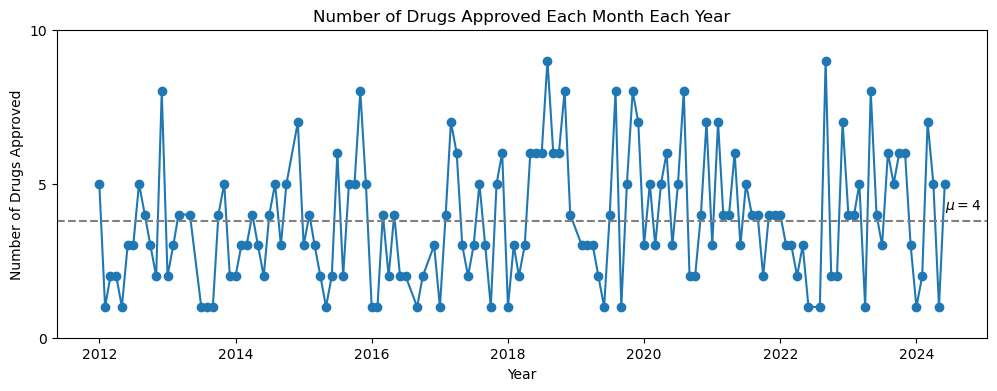

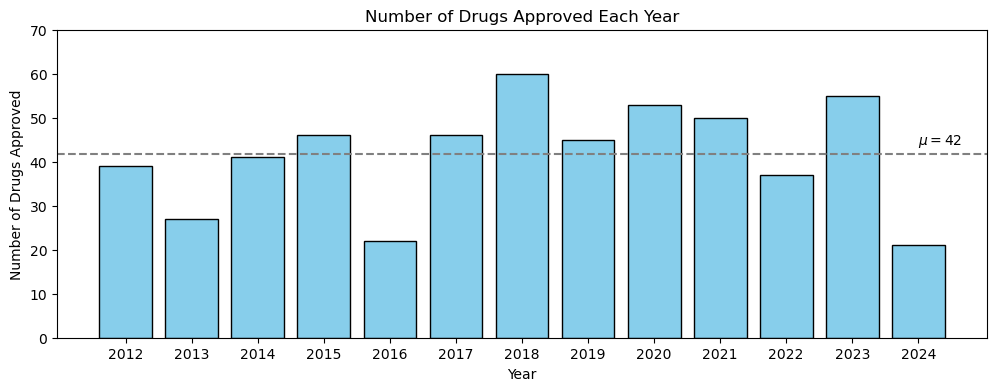

In [45]:
# plot number of drugs approved each month each year
def plot_nce_monthly(df_all):
	# convert approval_date to datetime
	approval_dates = pd.to_datetime(df_all['approval_date'])
	df_all['year_month'] = approval_dates.dt.to_period('M')
	df_all['year_month'] = df_all['year_month'].dt.to_timestamp()
	df_all['year_month'] = df_all['year_month'].dt.strftime('%Y-%m')
	df_all['year_month'] = pd.to_datetime(df_all['year_month'])
	df_all['year_month'] = df_all['year_month'].dt.strftime('%Y-%m')
	df_all['year_month'] = pd.to_datetime(df_all['year_month'])
	df_all['year'] = df_all['year_month'].dt.year
	df_all['count'] = 1
	df_all_grouped = df_all.groupby(['year_month', 'year']).count().reset_index()
	df_all_grouped = df_all_grouped[['year_month', 'count']]
	# plot
	f, ax = plt.subplots(1, 1, figsize=(12, 4))
	ax.plot(df_all_grouped['year_month'], df_all_grouped['count'], marker='o')
	# show each month-year on x-axis
	ax.set_xlabel('Year')
	ax.set_ylabel('Number of Drugs Approved')
	ax.set_title('Number of Drugs Approved Each Month Each Year')
	ax.set_ylim(0, 10)
	# y-axis shows 0-5-10
	ax.set_yticks(range(0, 11, 5))
	# plot average line
	ax.axhline(df_all_grouped['count'].mean(), color='grey', linestyle='--', label='Average')
	# show text above the average line at the end of the line with the greek letter mu = mean
	ax.text(df_all_grouped['year_month'].iloc[-1], df_all_grouped['count'].mean()+0.5, 
				 	f'$\mu = {round(df_all_grouped["count"].mean())}$', va='center', fontsize=10)
	plt.show()

def plot_yearly(df_all_grouped):
	# plot the number of drugs approved each year
	f, ax = plt.subplots(1, 1, figsize=(12, 4))
	ax.bar(df_all_grouped['year'], df_all_grouped['count'], ec='black', color='skyblue')
	# show each year on x-axis
	ax.set_xlabel('Year')
	ax.set_ylabel('Number of Drugs Approved')
	ax.set_title('Number of Drugs Approved Each Year')
	# show all years
	ax.set_xticks(df_all_grouped['year'])
	ax.set_ylim(0, 70)
	# y-axis shows 0-50-100
	ax.set_yticks(range(0, 80, 10))
	# dotted line for average across all years
	ax.axhline(df_all_grouped['count'].mean(), color='grey', linestyle='--', label='Average')
	# show text above the average line at the end of the line with the greek letter mu = mean
	ax.text(df_all_grouped['year'].iloc[-1], df_all_grouped['count'].mean()+3, 
				 	f'$\mu = {round(df_all_grouped["count"].mean())}$', va='center')
	plt.show()

def group_by_year(df_all):
	df_all['approval_date'] = pd.to_datetime(df_all['approval_date'])
	df_all['year'] = df_all['approval_date'].dt.year
	df_all['month'] = df_all['approval_date'].dt.month
	df_all_grouped = df_all.groupby(['year']).count().reset_index()
	df_all_grouped = df_all_grouped[['year', 'drug_name']]
	df_all_grouped.columns = ['year', 'count']
	return df_all_grouped

plot_nce_monthly(fda_drug_df)

drug_df_grouped = group_by_year(fda_drug_df)
plot_yearly(drug_df_grouped)

In [249]:
[drug for drug in fda_drug_df['active_ingredient'] if ',' in drug]

['sodium picosulfate, magnesium oxide and citric acid',
 'elvitegravir, cobicistat, emtricitabine, tenofovir disoproxil fumarate',
 '(ombitasvir, paritaprevir and ritonavir tablets co-packaged with dasabuvir tablets)',
 'a fixed-dose combination tablet containing elvitegravir, cobicistat, emtricitabine, and tenofovir alafenamide',
 'sofosbuvir, velpatasvir and voxilaprevir',
 'bictegravir, embitcitabine, tenofovir alafenamide',
 'imipenem, cilastatin and relebactam',
 'atoltivimab, maftivimab, and odesivimab-ebgn',
 'vonoprazan, amoxicillin, and clarithromycin',
 'sulbactam, durlobactam',
 'nirmatrelvir, ritonavir',
 'taurolidine, heparin',
 'cefepime, enmetazobactam']

In [51]:
# count the number of drugs that have either a CID or SID
def count_pubchem_ids(pubchem_df):
	cid_count = 0
	sid_count = 0
	for i, row in pubchem_df.iterrows():
		if row['cid'] != None:
			cid_count += 1
		if row['sid'] != None:
			sid_count += 1
	print(f'Number of drugs with CID: {cid_count}/{len(pubchem_df)}')
	print(f'Number of drugs with SID: {sid_count}/{len(pubchem_df)}')
	# print the drugs missing SID
	missing_sid = pubchem_df[pubchem_df['sid'].isnull()]
	print('  Drugs missing SID:')
	print(missing_sid[['drug_name', 'active_ingredient']])

count_pubchem_ids(pubchem_df)

Number of drugs with CID: 372/541
Number of drugs with SID: 536/541
  Drugs missing SID:
     drug_name            active_ingredient
504  Pombiliti    cipaglucosidase alfa-atga
513  Defencath         taurolidine, heparin
515   Ryzneuta  efbemalenograstim alfa-vuxw
522   Exblifep     cefepime, enmetazobactam
523     Letybo     letibotulinumtoxinA-wlbg


***
## Clinical Trials Search
Now we can use the drug name/active ingredients for all NMEs, as well as the synonyms retrieved from PubChem, to search for all clinical trials linked to each compound.

In [73]:
# open pytrials_fields.csv
def read_pytrials_fields():
	if not os.path.exists('databases/pytrials_fields.csv'):
		print('pytrials_fields.csv not found...')
		return None
	pytrial_fields = pd.read_csv('databases/pytrials_fields.csv')
	ct_fields = pytrial_fields['Column Name'].values
	print('pytrials fields:')
	[print(f'  {field}') for field in ct_fields]
	return ct_fields

ct_fields = read_pytrials_fields()

pytrials fields:
  NCT Number
  Study Title
  Study URL
  Acronym
  Study Status
  Brief Summary
  Study Results
  Conditions
  Interventions
  Primary Outcome Measures
  Secondary Outcome Measures
  Other Outcome Measures
  Sponsor
  Collaborators
  Sex
  Age
  Phases
  Enrollment
  Funder Type
  Study Type
  Study Design
  Other IDs
  Start Date
  Primary Completion Date
  Completion Date
  First Posted
  Results First Posted
  Last Update Posted
  Locations
  Study Documents


### Find Clinical Trials 

We will now find all clinical trials involved with each drug, including all of their synonyms found from PubChem.

In [74]:
def flatten(items, seqtypes=(list, tuple)):
	for i, x in enumerate(items):
		while i < len(items) and isinstance(items[i], seqtypes):
			items[i:i+1] = items[i]
	return items

def flatten_remove_duplicates(messy_list):
	clean_list = []
	for item in messy_list:
		# flatten list
		flattened_item = flatten(item)
		# remove duplicates
		clean_item = list(set(flattened_item))
		clean_list.append(clean_item)
	return clean_list

def parse_ctgov_synonyms(pubchem_df, ctgov_df, ct, drug_name):
	if drug_name not in pubchem_df['drug_name'].values:
		# print(f'{drug_name} not found in pubchem_df...')
		return None
	synonyms = pubchem_df[pubchem_df['drug_name'] == drug_name].compound_synonyms.values[0]
	if synonyms is None:
		# print(f'No synonyms found for {drug_name}...')
		return ctgov_df
	print(f'Number of synonyms for {drug_name}: {len(synonyms)}')
	synonyms = [synonym.lower() for synonym in synonyms]
	synonyms = [synonym.replace(' ', '+') for synonym in synonyms]
	ct_gov_count = 0
	for synonym in synonyms:
		try:
			# get the NCTId, Condition and Brief title fields from 1000 studies related to Coronavirus and Covid, in csv format.
			ct_output = ct.get_study_fields(
				search_expr=synonym,
				fields=ct_fields,
				max_studies=1000,
				fmt="csv",
			)
			if ct_output is None:
				# print(f'    No clinical trials found for {synonym}...')
				continue
			# print(f'    Number of clinical trials found for {synonym}: {len(ct_output)}')
			row_header = ['Drug Name', 'Search Term'] + ct_output[0]
			# add all rows to the dataframe
			for row in ct_output[1:]:
				ctgov_df = pd.concat([ctgov_df, pd.DataFrame([drug_name, synonym] + row, index=row_header).T], ignore_index=True)
				ct_gov_count += 1
		except:
			# print(f'  Error parsing {drug_name} - {synonym}...')
			continue
	print(f'  Number of CTs found: {ct_gov_count}')
	return ctgov_df

def clean_ctgov_df(ctgov_df):
	# drop rows with the same 'NCT Number' but combine the 'Search Term' fields and keep the first for all other fields
	agg_dict = {field: 'first' for field in ctgov_df.columns if field not in ['Drug Name', 'Search Term']}
	# combine 'Search Term' fields but don't have duplicates
	agg_dict['Drug Name'] = list
	agg_dict['Search Term'] = list
	ctgov_df = ctgov_df.groupby('NCT Number', as_index=False).agg(agg_dict)
	print('Number of rows in ctgov_df after dropping duplicates:', len(ctgov_df))
	# move 'Search Term' to the first column
	ctgov_df = ctgov_df[['Drug Name', 'Search Term'] + [col for col in ctgov_df.columns if col not in ['Drug Name', 'Search Term']]]
	# for each row, if there are duplicates in 'Drug Name' and 'Search Term' lists, keep only the first and flatten the lists
	drug_names = ctgov_df['Drug Name'].values
	search_terms = ctgov_df['Search Term'].values
	ctgov_df['Drug Name'] = flatten_remove_duplicates(drug_names)
	ctgov_df['Search Term'] = flatten_remove_duplicates(search_terms)
	return ctgov_df

def get_ctgov_synonyms(pubchem_df):
	ct = ClinicalTrials()
	# create a dataframe
	ctgov_df = pd.DataFrame(columns=['Drug Name', 'Search Term'] + list(ct_fields))
	for d_index, drug in enumerate(pubchem_df['drug_name'].values):
		ctgov_df = parse_ctgov_synonyms(pubchem_df, ctgov_df, ct, drug)
	# clean the dataframe
	ctgov_df = clean_ctgov_df(ctgov_df)
	return ctgov_df

# ctgov_df = get_ctgov_synonyms(pubchem_df)
ctgov_df = df_dict['ctgov_df']
ctgov_df

,Drug Name,Search Term,NCT Number,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,...,Study Design,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents
0,[Cholbam],[chd],NCT00000108,Effects of Training Intensity on the CHD Risk ...,https://clinicaltrials.gov/study/NCT00000108,,COMPLETED,The purpose of this research is to find out wh...,NO,Cardiovascular Diseases|Coronary Disease,...,Allocation: RANDOMIZED|Intervention Model: PAR...,NCRR-M01RR00042-1647|M01RR000042,,,,2000-01-19,,2005-06-24,3060G Central Campus Recreation Bldg 401 Washt...,
1,[Lumason],"[sulfur+hexafluoride, sulphur+hexafluoride, he...",NCT00000140,The Silicone Study,https://clinicaltrials.gov/study/NCT00000140,,COMPLETED,"To compare, through a randomized, multicenter ...",NO,Proliferative Vitreoretinopathy|Retinal Detach...,...,Allocation: RANDOMIZED|Intervention Model: |Ma...,NEI-39,1985-09,,,1999-09-24,,2005-06-24,,
2,[Exxua],"[bmy-13805, mj13805, gepirone, mj+13805, bmy+1...",NCT00000189,Gepirone vs Placebo in Treatment of Cocaine De...,https://clinicaltrials.gov/study/NCT00000189,,COMPLETED,The purpose of this study is to test antidepre...,NO,Cocaine-Related Disorders,...,Allocation: RANDOMIZED|Intervention Model: PAR...,NIDA-00144-3|3R01DA012268|K20-00144-3,1990-01,1991-02,1991-02,1999-09-21,,2015-05-28,"University of Pennsylvania, Philadelphia, Penn...",
3,[Lucemyra],"[lofexidine+monohydrochloride, lofexidine++hcl...",NCT00000345,Evaluation of Lofexidine for Treatment of Opia...,https://clinicaltrials.gov/study/NCT00000345,,COMPLETED,The purpose of this study is to assess the saf...,NO,Opioid-Related Disorders,...,Allocation: |Intervention Model: |Masking: NON...,NIDA-3-0010-10|Y01-3-0010-10,1996-04,,,1999-09-21,,2017-01-12,"Friends Research Institute, Los Angeles, Calif...",
4,[Lucemyra],"[lofexidine+monohydrochloride, lofexidine++hcl...",NCT00000354,Evaluation of Lofexidine for Treatment of Opio...,https://clinicaltrials.gov/study/NCT00000354,,COMPLETED,The purpose of this study is to determine the ...,NO,Opioid-Related Disorders|Substance-Related Dis...,...,Allocation: |Intervention Model: |Masking: |Pr...,NIDA-3-0012-3|Y01-3-0012-3,1996-07,1997-09,1997-12,1999-09-21,,2017-01-12,"University of Pennsylvania, Philadelphia, Penn...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46046,[Myrbetriq],"[mirabegron, betanis, ym-178, ym+178, ym178, m...",NCT06479720,Efficacy of Solifenacin or Mirabegron With Loc...,https://clinicaltrials.gov/study/NCT06479720,,RECRUITING,To investigates the effects of solifenacin or ...,NO,"Effect of Drug|Urinary Bladder, Overactive",...,Allocation: RANDOMIZED|Intervention Model: PAR...,22MMHIS039e-3,2022-06-16,2024-12-31,2025-06-30,2024-06-28,,2024-06-28,"Mackay Memorial Hospital, Taipei, Taiwan",
46047,"[NETSPOT, Ga-68-DOTATOC]","[gallium-dota-octreotate+ga-68, ga+68+dotatoc,...",NCT06479811,[212Pb]VMT-Alpha-NET in Metastatic or Inoperab...,https://clinicaltrials.gov/study/NCT06479811,,NOT_YET_RECRUITING,Background:Some cancers have high levels of pr...,NO,Somatostatin Receptor Positive|Gastrointestina...,...,Allocation: NON_RANDOMIZED|Intervention Model:...,10001709|001709-C,2024-07-03,2029-01-01,2032-01-01,2024-06-28,,2024-06-28,"National Institutes of Health Clinical Center,...",
46048,[Leqvio],[cemdisiran],NCT06479863,Efficacy and Safety of Pozelimab and Cemdisira...,https://clinicaltrials.gov/study/NCT06479863,,NOT_YET_RECRUITING,To evaluate the efficacy of Pozelimab/Cemdisir...,NO,Sporadic Inclusion Body Myositis (sIBM)|Idiopa...,...,Allocation: NA|Intervention Model: SINGLE_GROU...,R3918-OT-2383,2024-07-15,2027-05-30,2027-08-30,2024-06-28,,2024-06-28,"Austin Neuromuscular Center, Austin, Texas, 78...",
46049,[Elrexfio],[elrexfio],NCT06479954,Non Interventional Study to Investigate the Sa...,https://clinicaltrials.gov/study/NCT06479954,,NOT_YET_RECRUITING,To i

In [29]:
pickle_dataframe(pubchem_df, 'databases/pubchem_df.pkl')
pickle_dataframe(ctgov_df, 'databases/ctgov_df.pkl')

databases/pubchem_df.pkl file size: 1.322678 MB
databases/ctgov_df.pkl file size: 251.332878 MB


In [ ]:
from utils.pickle_dataframes import unpickle_dataframes
dataframes_dict = unpickle_dataframes()

In [180]:
import numpy as np
from xml.etree.ElementTree import iterparse

# read drugbank_database.xml
def read_drugbank():
	if not os.path.exists('databases/drugbank_database.xml'):
		print('drugbank_database.xml not found...')
		return None
	data = []
	for event, elem in iterparse('databases/drugbank_database.xml', events=("start", "end")):
		if elem.tag == "TimeStep" and event == 'start':
			TS = elem.attrib['TS']
			elem.clear()
		if elem.tag == "Particle" and event == 'start':
			cdata = elem.text.split(',')
			data.append([TS, elem.attrib['PT'], cdata[0], cdata[1]])
			elem.clear()
	return data

drugbank_xml = read_drugbank()

***
## All Approved FDA Drugs 

In [132]:
import re
# scrape all drugs from https://www.accessdata.fda.gov/scripts/cder/daf/index.cfm
def scrape_fda_daf():
	base_link = 'https://www.accessdata.fda.gov'
	home_page = '/scripts/cder/daf/index.cfm'
	drug_alpha_link = base_link + home_page + '?event=browseByLetter.page&productLetter='
	alphabet = list(string.ascii_uppercase)
	print(f'Scraping drug links from {base_link + home_page}...')
	approved_drugs_df = pd.DataFrame(columns=["drug_name", "drug_dosage", "drug_link", "ANDA", "sponsor"])
	for letter in alphabet:
		print('  Scraping drugs starting with letter:', letter)
		url = f'{drug_alpha_link}{letter}'
		response = test_connection(url)
		soup = BeautifulSoup(response.text, "html.parser")
		# get all rows from <table class="table table-bordered table-striped footable toggle-square-filled"
		rows = soup.find_all("table", class_="table table-bordered table-striped footable toggle-square-filled")[0].find_all("tr")
		# get <a data-toggle="collapse" data-parent="#accordion1" title="Click to expand drug name" href="#drugName25">A-POXIDE</a> -> A-POXIDE
		for row in rows:
			# print(row)
			drug_row = row.find_all("a")
			if len(drug_row) == 0:
				continue
			drug_name = drug_row[0].get_text()
			for drug in drug_row[1:]:
				drug_link = base_link + drug["href"]
				drug_info_split = drug["title"].split(" | ")
				# get active ingredient
				active_ingredient = drug_info_split[0].replace('Click to view', '').strip()
				# get application number (#040666 -> 040666)
				try:
					application_number = re.search(r'\d+', drug_info_split[1]).group()
				except:
					print(f'    No application number found for {drug_name}')
					application_number = None
				# get dosage form
				try:
					dosage_form = drug_info_split[2].strip().split(';')
				except:
					print(f'    No dosage form found for {drug_name}')
					dosage_form = None
				# get sponsor
				try:
					sponsor = drug_info_split[3].strip()
				except:
					print(f'    No sponsor found for {drug_name}')
					sponsor = None
				# add to the dataframe
				approved_drugs_df = pd.concat([approved_drugs_df, pd.DataFrame({
					"drug_name": [drug_name],
					"drug_dosage": [active_ingredient],
					"drug_link": [drug_link],
					"ANDA": [application_number],
					"sponsor": [sponsor]
				})], ignore_index=True)
	print(f'Number of drugs scraped: {len(approved_drugs_df["drug_name"].unique())}')
	return approved_drugs_df

approved_drugs_df = scrape_fda_daf()

Scraping drug links from https://www.accessdata.fda.gov/scripts/cder/daf/index.cfm...
  Scraping drugs starting with letter: A
  Scraping drugs starting with letter: B
  Scraping drugs starting with letter: C
    No application number found for CLOPRA-"YELLOW"
    No dosage form found for CLOPRA-"YELLOW"
    No sponsor found for CLOPRA-"YELLOW"
  Scraping drugs starting with letter: D
  Scraping drugs starting with letter: E
  Scraping drugs starting with letter: F
  Scraping drugs starting with letter: G
    No application number found for GERMA-MEDICA "MG"
    No dosage form found for GERMA-MEDICA "MG"
    No sponsor found for GERMA-MEDICA "MG"
  Scraping drugs starting with letter: H
    No application number found for HY-PAM "25"
    No dosage form found for HY-PAM "25"
    No sponsor found for HY-PAM "25"
    No application number found for HYDRO-SERP "25"
    No dosage form found for HYDRO-SERP "25"
    No sponsor found for HYDRO-SERP "25"
    No application number found for HYDR

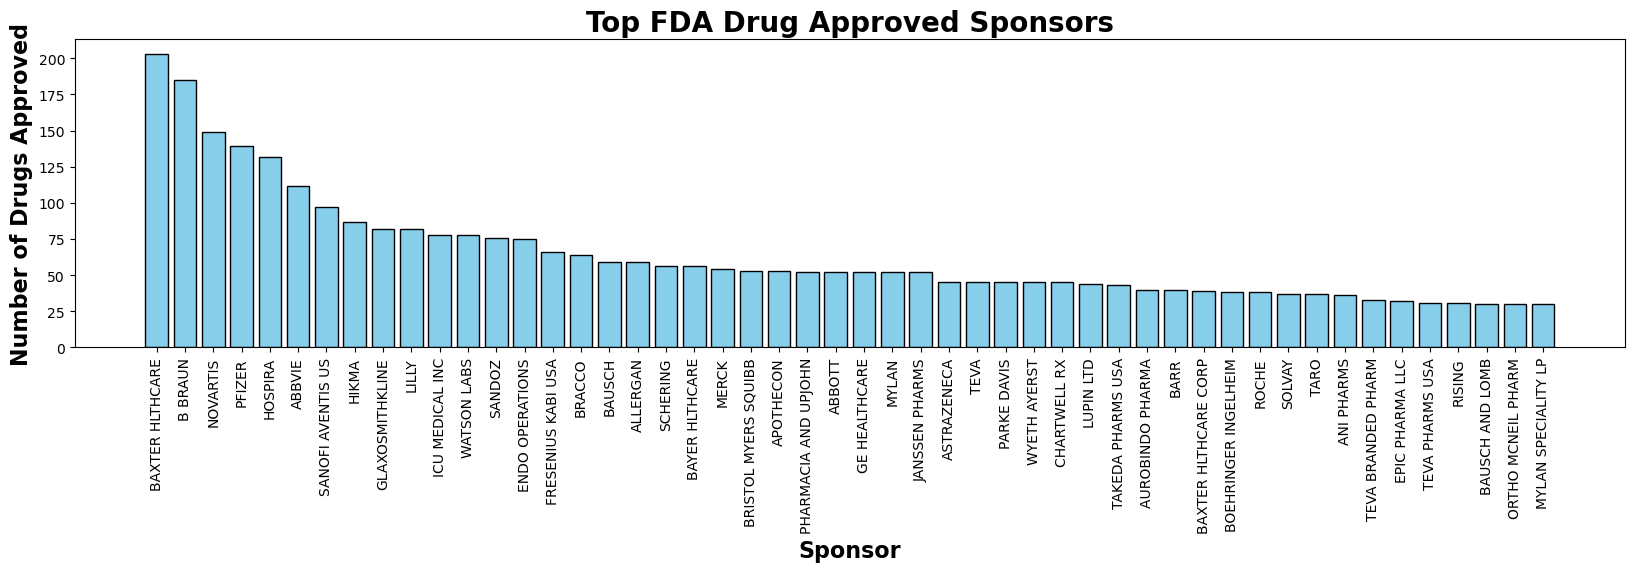

In [145]:
# make a plot with the largest number of sponsors
def plot_sponsors(approved_drugs_df):
	unique_drugs_df = approved_drugs_df.drop_duplicates(subset=['drug_name'])
	# get the top 10 sponsors
	top_sponsors = unique_drugs_df['sponsor'].value_counts().nlargest(50)
	# plot
	f, ax = plt.subplots(1, 1, figsize=(20, 4))
	ax.bar(top_sponsors.index, top_sponsors.values, color='skyblue', edgecolor='black')
	# rotate x-axis labels
	plt.xticks(rotation=90, fontsize=10)
	# show each sponsor on x-axis
	ax.set_xlabel('Sponsor', fontsize=16, fontweight='bold')
	ax.set_ylabel('Number of Drugs Approved', fontsize=16, fontweight='bold')
	ax.set_title('Top FDA Drug Approved Sponsors', fontsize=20, fontweight='bold')
	plt.show()

plot_sponsors(approved_drugs_df)

***
## NIH DailyMed

### Old Version Hide

In [ ]:
# def get_dailymed_drug_classes():
# 	base_url = 'https://dailymed.nlm.nih.gov/dailymed/browse-drug-classes.cfm?page='
# 	suffix_list = ['a#listing', 'b-c#listing', 'd-g#listing', 'h-l#listing', 'm-o#listing', 'p-z#listing']
# 	all_drug_classes = {}
# 	for suffix in suffix_list:
# 		url = base_url + suffix
# 		response = test_connection(url)
# 		soup = BeautifulSoup(response.text, 'html.parser')
# 		# get all a hrefs
# 		links = soup.find_all('a', href=True)
# 		# if the href contains '/dailymed/search.cfm?query' then it is a drug class
# 		for link in links:
# 			if '/dailymed/search.cfm?query' in link['href']:
# 				drug_class = link.text.strip()
# 				drug_link = link['href']
# 				all_drug_classes[drug_class] = drug_link
# 	return all_drug_classes

# def get_dailymed_drugs(all_drug_classes, drug_class):
# 	drug_class_df = pd.DataFrame(columns=['drug_name', 'drug_link', 'drug_class', 'ndc_code', 'packager'])
# 	base_url = 'https://dailymed.nlm.nih.gov'
# 	# get all pages for the drug class (add page=2, page=3, etc. to the url and test if the page exists)
# 	all_results_pages = []
# 	page_num = 1
# 	while True:
# 		url = base_url + all_drug_classes[drug_class] + '&pagesize=200' + f'&page={page_num}'
# 		response = test_connection(url)
# 		soup = BeautifulSoup(response.text, 'html.parser')
# 		# get all <div class="results-info"> tags
# 		results_info = soup.find_all('div', class_='results-info')
# 		# if there are no results, break
# 		if len(results_info) == 0:
# 			break
# 		# flatten the list and add to all_results_pages
# 		all_results_pages += results_info
# 		page_num += 1
# 	for result in all_results_pages:
# 		drug_name = None
# 		drug_link = None
# 		ndc_code = None
# 		packager = None
# 		# get the drug name
# 		drug_name = result.find('a').text
# 		# get the drug link
# 		drug_link = base_url+result.find('a')['href']
# 		# get the ndc code (<span class="ndc-codes">)
# 		ndc_code = None
# 		ndc_code_text = result.find('span', class_='ndc-codes')
# 		if ndc_code_text is not None:
# 			ndc_code = ndc_code_text.text
# 			ndc_code = list(set([code.strip() for code in ndc_code.split(',')]))
# 		# get the packager (<li><strong>Packager:</strong> <span>Akorn</span></li>)
# 		packager = result.find('li').find('span').text.strip()
# 		# add to the dataframe
# 		drug_class_df = pd.concat([drug_class_df, pd.DataFrame({
# 			"drug_name": [drug_name],
# 			"drug_link": [drug_link],
# 			"drug_class": [drug_class],
# 			"ndc_code": [ndc_code],
# 			"packager": [packager]
# 		})], ignore_index=True)	
# 	print(f'  Number of drugs added: {len(drug_class_df)}')
# 	return drug_class_df

# # create a dataframe
# dailymed_df = pd.DataFrame(columns=['drug_name', 'drug_class', 'drug_link', 'ndc_code', 'packager'])
# for d_index, drug_class in enumerate(all_drug_classes['epc']):
# 	print(f'Getting drugs for {drug_class}...')
# 	dailymed_df = pd.concat([dailymed_df,
# 													get_dailymed_drugs(all_drug_classes, drug_class)], 
# 													ignore_index=True)

### Scrape DailyMed Drugs
DailyMed is an NIH-managed website that comprehensively contains label information for all FDA-regulated products.

> Example: [Keytruda Listing](https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=9333c79b-d487-4538-a9f0-71b91a02b287)

In [299]:
def get_dailymed_drug_classes():
	print(f'Scraping drug classes from DailyMed...')
	base_url = 'https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100'
	class_types = ['epc', 'moa', 'pe', 'ci']
	all_drug_classes = defaultdict(list)
	for class_type in class_types:
		page = 1
		while True:
			url = f'{base_url}&class_code_type={class_type}&page={page}'
			response = test_connection(url)
			soup = BeautifulSoup(response.text, 'xml')
			# find all <drugclass> tags and get type and name
			drug_classes = soup.find_all('drugclass')
			if len(drug_classes) == 0:
				break
			else:
				for drug_class in drug_classes:
					class_name = drug_class.find('name').get_text()
					all_drug_classes[class_type].append(class_name)
			page += 1
		print(f'  Number of {class_type} classes: {len(all_drug_classes[class_type])}')
	return all_drug_classes

all_drug_classes = get_dailymed_drug_classes()

https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=1
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=2
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=3
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=4
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=5
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=6
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=7
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=epc&page=8
https://dailymed.nlm.nih.gov/dailymed/services/v2/drugclasses.xml?pagesize=100&class_code_type=moa&page=1
https://dailymed.nlm.nih.gov/dailymed/services

In [68]:
def get_dailymed_drug_info(url):
	drug_name = None
	ndc_code = None
	packager = None
	response = test_connection(url)
	soup = BeautifulSoup(response.text, 'html.parser')
	# get h1 tag for the drug name
	drug_name = soup.find_all('h1')[0].get_text().replace('Label: ', '').strip()
	# drug info is in <ul class="drug-information">
	drug_info = soup.find_all('ul', class_='drug-information')[0]
	ndc_code_text = drug_info.find('span', id='item-code-s')
	if ndc_code_text is not None:
		ndc_code = ndc_code_text.text
		ndc_code = list(set([code.strip() for code in ndc_code.split(',')]))
	packager_find = drug_info.find_all('li')
	if len(packager_find) > 1:
		packager = packager_find[1].text.replace('Packager: ', '').strip()
	return drug_name, url, ndc_code, packager

def insert_drug_info(drug_name, drug_class, class_type, drug_link, ndc_code, packager, df):
	df = pd.concat([df, pd.DataFrame({
		"drug_name": [drug_name],
		"drug_class": [drug_class],
		"class_type": [class_type.upper()],
		"drug_link": [drug_link],
		"ndc_code": [ndc_code],
		"packager": [packager]
	})], ignore_index=True)
	return df

def get_dailymed_drugs(all_drug_classes, drug_class, class_type):
	drug_class_df = pd.DataFrame(columns=['drug_name', 'drug_class', 'class_type', 'drug_link', 'ndc_code', 'packager'])
	base_url = f'https://dailymed.nlm.nih.gov/dailymed/search.cfm?query={drug_class}'
	# get all pages for the drug class (add page=2, page=3, etc. to the url and test if the page exists)
	all_results_pages = []
	page_num = 1
	while True:
		url = base_url + '&pagesize=200' + f'&page={page_num}'
		response = test_connection(url)
		soup = BeautifulSoup(response.text, 'html.parser')
		# get all <div class="results-info"> tags for drug classes that have multiple entries
		results_info = soup.find_all('div', class_='results-info')
		# if there are no results, break
		if len(results_info) == 0 and page_num == 1:
			drug_name, drug_link, ndc_code, packager = get_dailymed_drug_info(url)
			drug_class_df = insert_drug_info(drug_name, drug_class, class_type, drug_link, ndc_code, packager, drug_class_df)
		elif len(results_info) == 0 and page_num > 1:
			break
		# flatten the list and add to all_results_pages
		all_results_pages += results_info
		page_num += 1
	if len(all_results_pages) > 0:
		for result in all_results_pages:
			drug_name = None
			drug_link = None
			ndc_code = None
			packager = None
			# get the drug name
			drug_name = result.find('a').text
			# get the drug link
			drug_link = base_url+result.find('a')['href']
			# get the ndc code (<span class="ndc-codes">)
			ndc_code = None
			ndc_code_text = result.find('span', class_='ndc-codes')
			if ndc_code_text is not None:
				ndc_code = ndc_code_text.text
				ndc_code = list(set([code.strip() for code in ndc_code.split(',')]))
			# get the packager (<li><strong>Packager:</strong> <span>Akorn</span></li>)
			packager = result.find('li').find('span').text.strip()
			# add to the dataframe
			drug_class_df = insert_drug_info(drug_name, drug_class, class_type, drug_link, ndc_code, packager, drug_class_df)
	print(f'    Number of drugs added: {len(drug_class_df)}')
	return drug_class_df

# create a dataframe
def scrape_dailymed():
	dailymed_df = pd.DataFrame(columns=['drug_name', 'drug_class', 'class_type', 'drug_link', 'ndc_code', 'packager'])
	for class_type in all_drug_classes.keys():
		print(f'Getting drugs for {class_type}...')
		for d_index, drug_class in enumerate(all_drug_classes[class_type]):
			print(f'  {drug_class}...({d_index+1}/{len(all_drug_classes[class_type])})')
			dailymed_df = pd.concat([dailymed_df,
															get_dailymed_drugs(all_drug_classes, drug_class, class_type)], 
															ignore_index=True)
	return dailymed_df

# dailymed_df = scrape_dailymed()
dailymed_df = df_dict['dailymed_df']
dailymed_df

,drug_name,drug_class,class_type,drug_link,ndc_code,packager
0,NITISINONE capsule,4-HYDROXYPHENYL-PYRUVATE DIOXYGENASE INHIBITOR,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[70505-202-60, 70505-220-60, 70505-210-60, 705...",Analog Pharma
1,NITISINONE capsule,4-HYDROXYPHENYL-PYRUVATE DIOXYGENASE INHIBITOR,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[71863-122-60, 71863-121-60, 71863-119-60, 718...","Eton Pharmaceuticals, Inc."
2,NITISINONE capsule,4-HYDROXYPHENYL-PYRUVATE DIOXYGENASE INHIBITOR,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[0254-3022-02, 0254-3021-02, 0254-3020-02]","Par Pharmaceutical, Inc."
3,NITYR (nitisinone) tablet,4-HYDROXYPHENYL-PYRUVATE DIOXYGENASE INHIBITOR,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[70709-005-60, 70709-000-60, 70709-002-60]",Cycle Pharmaceuticals Ltd.
4,ORFADIN (nitisinone) capsule,4-HYDROXYPHENYL-PYRUVATE DIOXYGENASE INHIBITOR,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[66658-110-60, 66658-102-60, 66658-105-60, 666...",SWEDISH ORPHAN BIOVITRUM AB (PUBL)
...,...,...,...,...,...,...
259388,PRENATAL VITAMINS PLUS tablet,VITAMIN B 6,CI,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[63629-3545-2, 63629-3545-3, 63629-3545-1]",Bryant Ranch Prepack
259389,"PREPLUS (vitamin a acetate, ascorbic acid, cho...",VITAMIN B 6,CI,https://dailymed.nlm.nih.gov/dailymed/search.c...,None,A-S Medication Solutions
259390,"PYRIDOXINE HCI injection, solution",VITAMIN B 6,CI,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[51662-1410-1, 51662-1410-2, 51662-1410-3]","HF Acquisition Co LLC, DBA HealthFirst"
259391,RENO CAPS capsule,VITAMIN B 6,CI,https://dailymed.nlm.nih.gov/dailymed/search.c...,[68151-1928-6],Carilion Materials Management


In [72]:
find_drug(dailymed_df, 'drug_class', ['radio', 'positron'])

Number of drug_class (['radio', 'positron']) drugs found: 603


,drug_name,drug_class,class_type,drug_link,ndc_code,packager
26437,ZEVALIN- ibritumomab tiuxetan kit,CD20-DIRECTED RADIOTHERAPEUTIC ANTIBODY,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,[72893-007-04],Acrotech Biopharma Inc
93924,AMMONIA N 13 (ammonia n-13) injection,RADIOACTIVE DIAGNOSTIC AGENT,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[76451-013-51, 76451-013-11, 76451-013-10]",3D Imaging Drug Design and Development LLC
93925,AMMONIA N 13 (ammonia n-13) injection,RADIOACTIVE DIAGNOSTIC AGENT,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[71162-001-05, 71162-001-10]",Ionetix Corporation
93926,AMMONIA N 13 (ammonia n-13) injection,RADIOACTIVE DIAGNOSTIC AGENT,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,[62072-456-56],Kreitchman PET Center
93927,AMMONIA N 13 (ammonia n-13) injection,RADIOACTIVE DIAGNOSTIC AGENT,EPC,https://dailymed.nlm.nih.gov/dailymed/search.c...,[40028-513-30],"PETNET Solutions, Inc."
...,...,...,...,...,...,...
194281,VIZAMYL (flutemetamol f-18) solution,RADIOPHARMACEUTICAL ACTIVITY,MOA,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[17156-067-30, 17156-067-10]","Medi-Physics, Inc. dba GE Healthcare"
194282,"VOLUMEX (iodinated i-131 albumin ) injection, ...",RADIOPHARMACEUTICAL ACTIVITY,MOA,https://dailymed.nlm.nih.gov/dailymed/search.c...,[50914-7720-8],"Iso-Tex Diagnostics, Inc."
194283,"XENON, XE-133 (xenon) gas",RADIOPHARMACEUTICAL ACTIVITY,MOA,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[69945-098-25, 69945-097-15, 69945-098-21, vie...",Curium US LLC
194284,XENON (xenon xe-133) gas,RADIOPHARMACEUTICAL ACTIVITY,MOA,https://dailymed.nlm.nih.gov/dailymed/search.c...,"[11994-128-21, 11994-128-25, 11994-127-15, 119...","Lantheus Medical Imaging, Inc."


In [348]:
# pickle the dataframe
pickle_dataframe(dailymed_df, 'databases/dailymed_df.pkl')

databases/dailymed_df.pkl file size: 90.126902 MB


In [59]:
# overlap_drugs = find_overlap(fda_drug_df, approved_drugs_df)
overlap_drugs = find_df_overlap(df_drug_classes, dailymed_df)

Number of drugs in df_1: 5948
Number of drugs in df_2: 29399
Number of drugs from df_1 in df_2: 20
  df_1 drugs missing in df_2: ['aminosyn', 'nephronex', 'adrenaclick', 'cuvrior', 'glucophage', 'mucinex nightshift sinus clear & cool', 'oasis moisturizing mouth', 'byetta', 'namenda', 'despec drops']...
Number of drugs from df_2 in df_1: 12958
  df_2 drugs missing in df_1: ['all day back and muscle pain relief (naproxen sodium) tablet, coated', 'zolpidem tartrate (zolpidem tartrate) tablet for oral use - civ', 'levofloxacin tablet, film coated', 'zileuton tablet, extended release', 'handy solutions headache pain relief (acetaminophen, aspirin, caffeine) tablet, film coated', 'topcare childrens allergy relief nasal 24 hour (fluticasone propionate) spray, metered', 'treatment set ts342922 injection, solution', 'esomeprazole magnesium tablet, delayed release', 'tacrolimus capsuletacrolimus (tacrolimus capsules) capsule', 'microgestin fe (norethindrone acetate and ethinyl estradiol and ferr

Number of unique drug classes: 613
Number of unique drugs: 28104


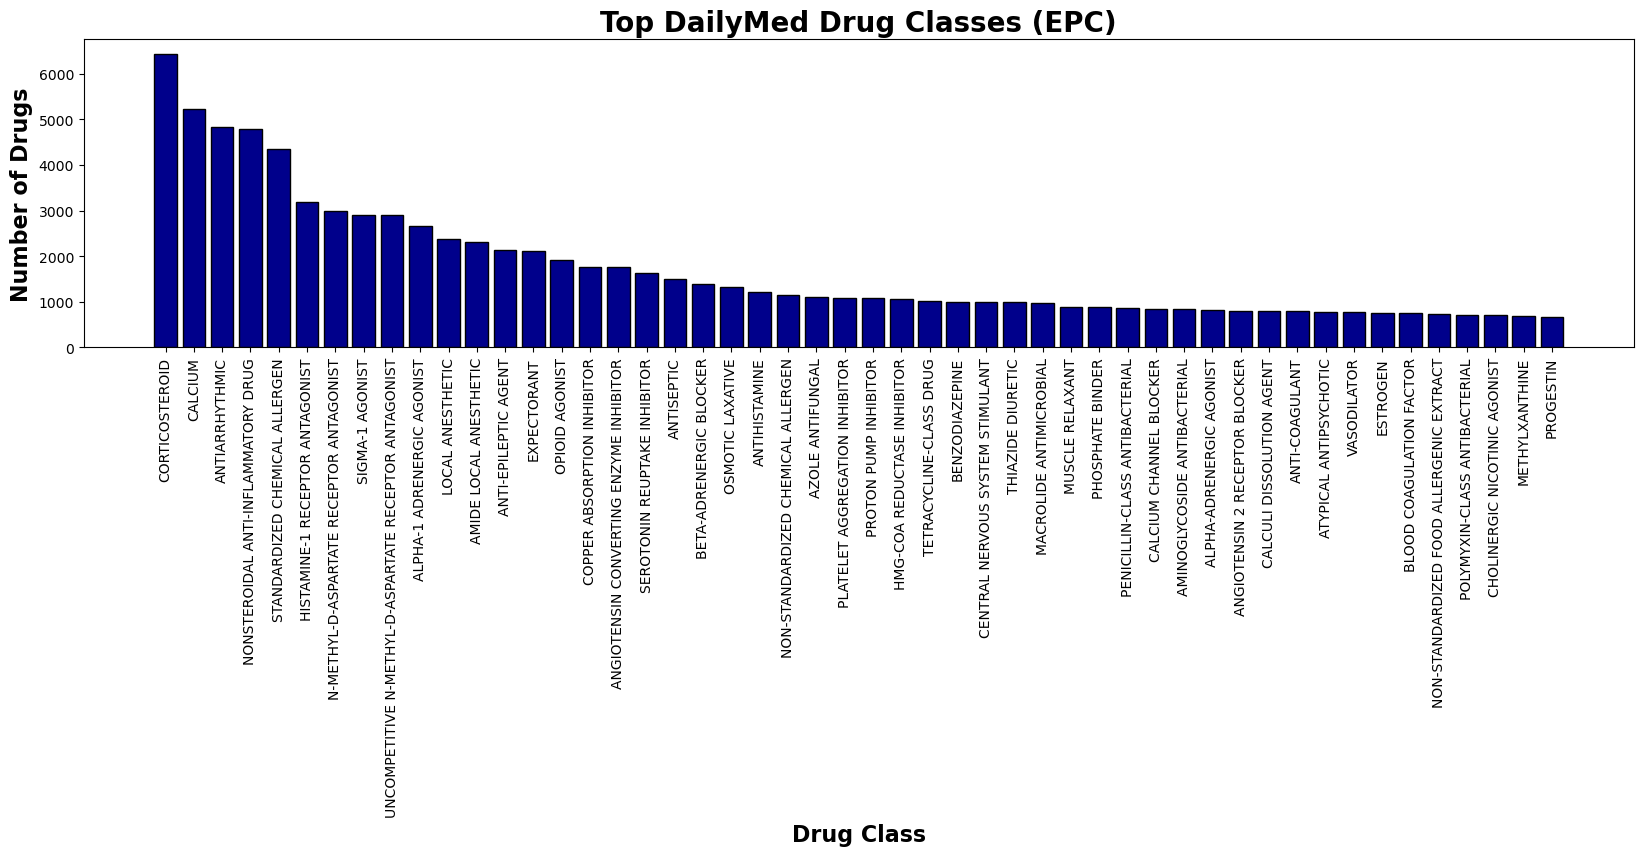

Number of unique drug classes: 373
Number of unique drugs: 14143


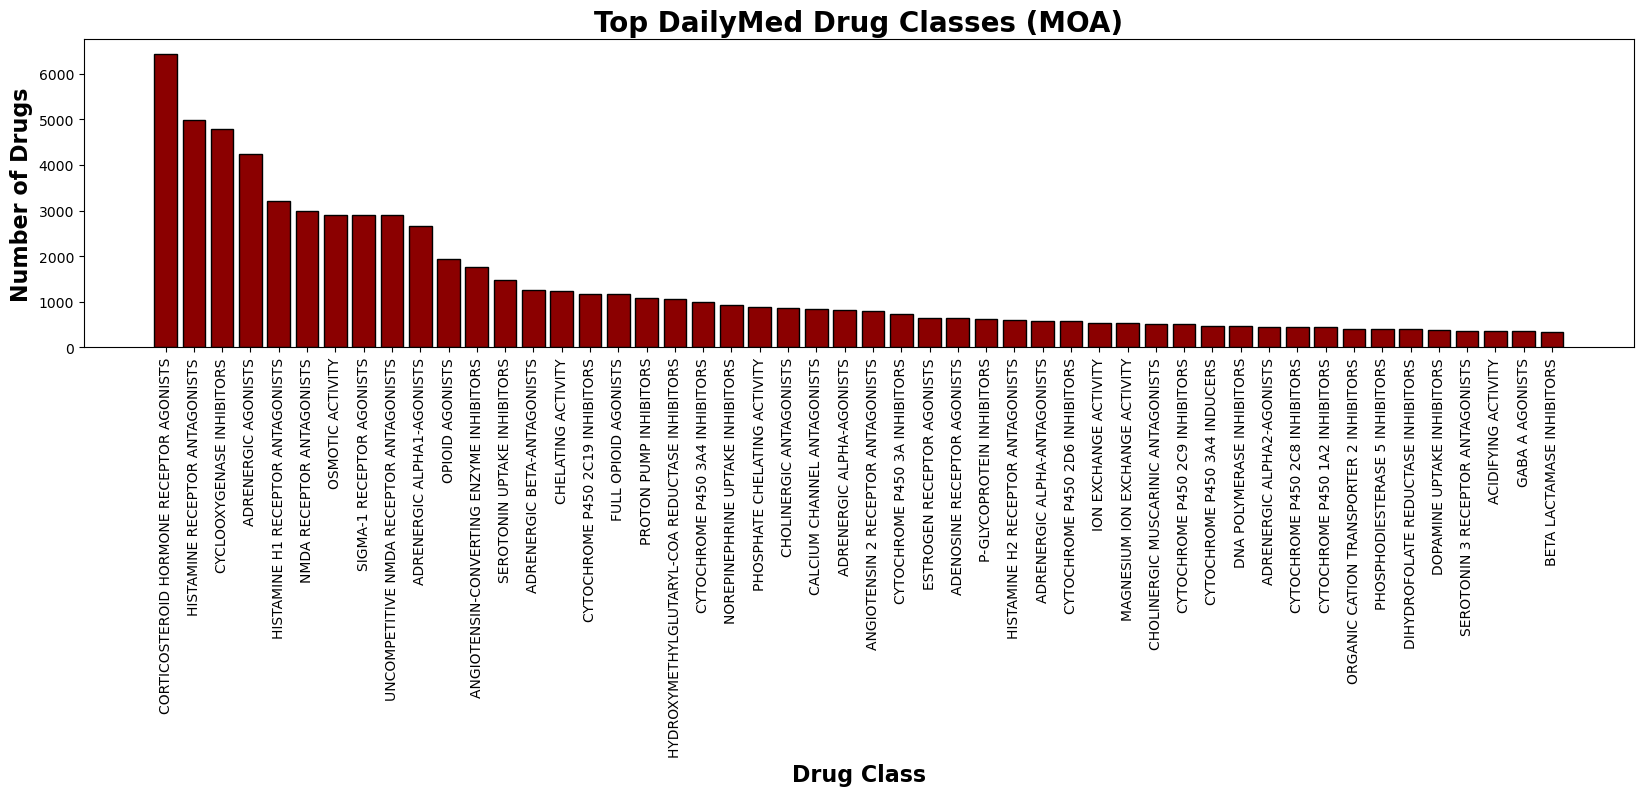

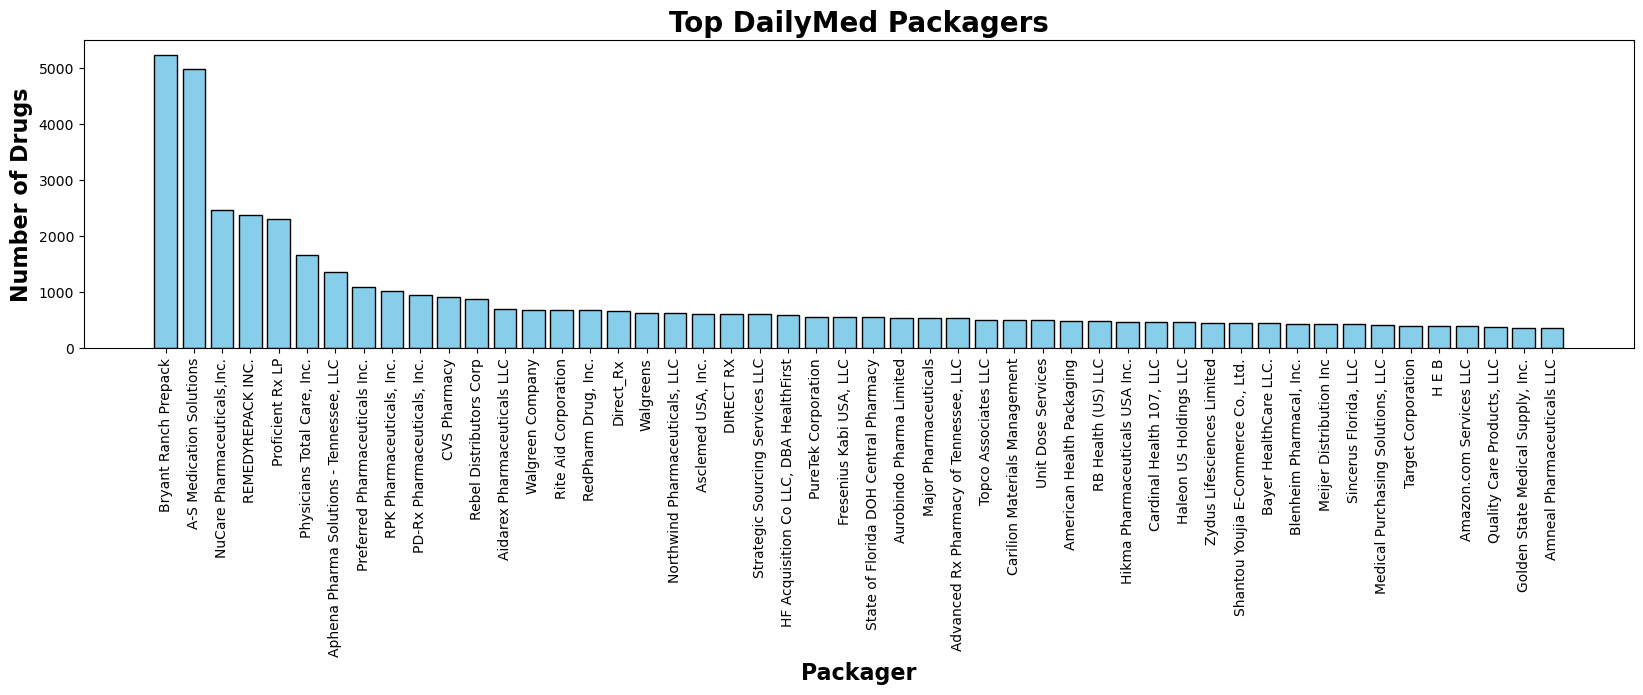

Number of unique packagers: 6735
Number of unique drugs: 28104


In [57]:
# plot the number of drugs in each drug class for the top 20 drug classes
def plot_drug_classes(df, class_type='EPC', color='darkblue'):
	# count only drug classes that have [class_type] in the name
	df['drug_class'] = df['drug_class'].str.upper()
	# remove NaN/None values
	df = df.dropna(subset=['drug_class'])
	df = df[df['class_type'].str.contains(class_type)]
	# get the top N drug classes
	top_drug_classes = df['drug_class'].value_counts().nlargest(50)
	f, ax = plt.subplots(1, 1, figsize=(20, 4))
	ax.bar(top_drug_classes.index, top_drug_classes.values, color=color, edgecolor='black')
	# rotate x-axis labels
	plt.xticks(rotation=90, fontsize=10)
	# show each drug class on x-axis
	ax.set_xlabel('Drug Class', fontsize=16, fontweight='bold')
	ax.set_ylabel('Number of Drugs', fontsize=16, fontweight='bold')
	ax.set_title(f'Top DailyMed Drug Classes ({class_type})', fontsize=20, fontweight='bold')
	# print the number of unique drug classes
	print(f'Number of unique drug classes: {len(df["drug_class"].unique())}')
	print(f'Number of unique drugs: {len(df["drug_name"].unique())}')
	plt.show()

def plot_packagers(dailymed_df):
	top_packagers = dailymed_df['packager'].value_counts().nlargest(50)
	f, ax = plt.subplots(1, 1, figsize=(20, 4))
	ax.bar(top_packagers.index, top_packagers.values, color='skyblue', edgecolor='black')
	# rotate x-axis labels
	plt.xticks(rotation=90, fontsize=10)
	# show each packager on x-axis
	ax.set_xlabel('Packager', fontsize=16, fontweight='bold')
	ax.set_ylabel('Number of Drugs', fontsize=16, fontweight='bold')
	ax.set_title('Top DailyMed Packagers', fontsize=20, fontweight='bold')
	plt.show()
	# print the number of unique packagers
	print(f'Number of unique packagers: {len(dailymed_df["packager"].unique())}')
	print(f'Number of unique drugs: {len(dailymed_df["drug_name"].unique())}')

plot_drug_classes(dailymed_df, class_type='EPC', color='darkblue')
plot_drug_classes(dailymed_df, class_type='MOA', color='darkred')
dailymed_df_epc = dailymed_df[dailymed_df['class_type'].str.contains('EPC')]
plot_packagers(dailymed_df_epc)